In [8]:
import math
import random
import torch
import time
from torch import nn
from torch.optim.optimizer import Optimizer
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from d2l import torch as d2l
from collections import deque
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [9]:
device = d2l.try_gpu()

In [21]:
class FCSGD_G_L(Optimizer):


    def __init__(self, params, lr=1e-1, weight_decay=1e-8,r=0.9):  #r on behalf of fractional order 
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))

        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        
        if not -2.0 <= r:
            raise ValueError("Invalid r value: {}".format(r))
            
        defaults = dict(lr=lr,weight_decay=weight_decay,r=r)
        super(FCSGD_G_L, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(FCSGD_G_L, self).__setstate__(state)
    
    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('FCSGD_G-L does not support sparse gradients')
                    
                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    
                    state['present_grad'] = torch.zeros_like(p.data)
                    
                    # Previous gradient
                    state['previous_grad_1'] = torch.zeros_like(p.data)
                    state['previous_grad_2'] = torch.zeros_like(p.data)
                    state['previous_grad_3'] = torch.zeros_like(p.data)
                    state['previous_grad_4'] = torch.zeros_like(p.data)
                    state['previous_grad_5'] = torch.zeros_like(p.data)
                    state['previous_grad_6'] = torch.zeros_like(p.data)
                    state['previous_grad_7'] = torch.zeros_like(p.data)
                    state['previous_grad_8'] = torch.zeros_like(p.data)
                    state['previous_grad_9'] = torch.zeros_like(p.data)
                    state['previous_grad_10'] = torch.zeros_like(p.data)
                    
                    #fractional order
                    r = group['r']
                    
                    #coefficients by a novel G-L
                    state['w0'] = 1
                    state['w1'] = (1-(r+1)/2)*state['w0']
                    state['w2'] = (1-(r+1)/3)*state['w1']
                    state['w3'] = (1-(r+1)/4)*state['w2']
                    state['w4'] = (1-(r+1)/5)*state['w3']
                    state['w5'] = (1-(r+1)/6)*state['w4']
                    state['w6'] = (1-(r+1)/7)*state['w5']
                    state['w7'] = (1-(r+1)/8)*state['w6']
                    state['w8'] = (1-(r+1)/9)*state['w7']
                    state['w9'] = (1-(r+1)/10)*state['w8']
                    state['w10'] = (1-(r+1)/11)*state['w9']
                    
                
                
                fractional_order_grad = state['present_grad']
                
                a = [1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
                random.shuffle(a)
                
                fractional_order_grad.add_(1,grad.clone())\
                .add_(a[0]*state['w1'],state['previous_grad_1'])\
                .add_(a[1]*state['w2'],state['previous_grad_2'])\
                .add_(a[2]*state['w3'],state['previous_grad_3'])\
                .add_(a[3]*state['w4'],state['previous_grad_4'])\
                .add_(a[4]*state['w5'],state['previous_grad_5'])\
                .add_(a[5]*state['w6'],state['previous_grad_6'])\
                .add_(a[6]*state['w7'],state['previous_grad_7'])\
                .add_(a[7]*state['w8'],state['previous_grad_8'])\
                .add_(a[8]*state['w9'],state['previous_grad_9'])\
                .add_(a[9]*state['w10'],state['previous_grad_10'])
                
                
                state['previous_grad_10'] = state['previous_grad_9']
                state['previous_grad_9'] = state['previous_grad_8']
                state['previous_grad_8'] = state['previous_grad_7']
                state['previous_grad_7'] = state['previous_grad_6']
                state['previous_grad_6'] = state['previous_grad_5']
                state['previous_grad_5'] = state['previous_grad_4']
                state['previous_grad_4'] = state['previous_grad_3']
                state['previous_grad_3'] = state['previous_grad_2']
                state['previous_grad_2'] = state['previous_grad_1']
                state['previous_grad_1'] = grad.clone()
                
                state['step'] += 1
                
                if group['weight_decay'] != 0:
                    fractional_order_grad.add_(group['weight_decay'], p.data)
                    
                fractional_order_grad_1 = fractional_order_grad
                
                state['present_grad'] = torch.zeros_like(p.data)
                
                step_size = group['lr']
                
                p.data.add_(-step_size, fractional_order_grad_1)
                
        return loss

In [11]:
class FCAdam_G_L(Optimizer):


    def __init__(self, params, lr=1e-1, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-8,r=0.9):  #r on behalf of fractional order 
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
         
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay)) 
        
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
            
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
            
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
            
        if not -2.0 <= r:
            raise ValueError("Invalid r value: {}".format(r))
            
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay,r=r)
        super(FCAdam_G_L, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(FCAdam_G_L, self).__setstate__(state)
        
    
    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('FCAdam_G_L does not support sparse gradients')

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    
                    state['present_grad'] = torch.zeros_like(p.data)
                    
                    # Previous gradient
                    state['previous_grad_1'] = torch.zeros_like(p.data)
                    state['previous_grad_2'] = torch.zeros_like(p.data)
                    state['previous_grad_3'] = torch.zeros_like(p.data)
                    state['previous_grad_4'] = torch.zeros_like(p.data)
                    state['previous_grad_5'] = torch.zeros_like(p.data)
                    state['previous_grad_6'] = torch.zeros_like(p.data)
                    state['previous_grad_7'] = torch.zeros_like(p.data)
                    state['previous_grad_8'] = torch.zeros_like(p.data)
                    state['previous_grad_9'] = torch.zeros_like(p.data)
                    state['previous_grad_10'] = torch.zeros_like(p.data)
                    
                    #fractional order
                    r = group['r']
                    
                    #coefficients by a novel G-L
                    state['w0'] = 1
                    state['w1'] = (1-(r+1)/2)*state['w0']
                    state['w2'] = (1-(r+1)/3)*state['w1']
                    state['w3'] = (1-(r+1)/4)*state['w2']
                    state['w4'] = (1-(r+1)/5)*state['w3']
                    state['w5'] = (1-(r+1)/6)*state['w4']
                    state['w6'] = (1-(r+1)/7)*state['w5']
                    state['w7'] = (1-(r+1)/8)*state['w6']
                    state['w8'] = (1-(r+1)/9)*state['w7']
                    state['w9'] = (1-(r+1)/10)*state['w8']
                    state['w10'] = (1-(r+1)/11)*state['w9']
                    
                    #initialize first moment and second moment
                    state['m'] = 0;state['v'] = 0
                
                fractional_order_grad = state['present_grad']
                
                a = [1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
                random.shuffle(a)
                
                fractional_order_grad.add_(1,grad.clone())\
                .add_(a[0]*state['w1'],state['previous_grad_1'])\
                .add_(a[1]*state['w2'],state['previous_grad_2'])\
                .add_(a[2]*state['w3'],state['previous_grad_3'])\
                .add_(a[3]*state['w4'],state['previous_grad_4'])\
                .add_(a[4]*state['w5'],state['previous_grad_5'])\
                .add_(a[5]*state['w6'],state['previous_grad_6'])\
                .add_(a[6]*state['w7'],state['previous_grad_7'])\
                .add_(a[7]*state['w8'],state['previous_grad_8'])\
                .add_(a[8]*state['w9'],state['previous_grad_9'])\
                .add_(a[9]*state['w10'],state['previous_grad_10'])
                
                state['previous_grad_10'] = state['previous_grad_9']
                state['previous_grad_9'] = state['previous_grad_8']
                state['previous_grad_8'] = state['previous_grad_7']
                state['previous_grad_7'] = state['previous_grad_6']
                state['previous_grad_6'] = state['previous_grad_5']
                state['previous_grad_5'] = state['previous_grad_4']
                state['previous_grad_4'] = state['previous_grad_3']
                state['previous_grad_3'] = state['previous_grad_2']
                state['previous_grad_2'] = state['previous_grad_1']
                state['previous_grad_1'] = grad.clone()
                
                beta1, beta2 = group['betas']

                state['step'] += 1
                
                if group['weight_decay'] != 0:
                    fractional_order_grad.add_(group['weight_decay'], p.data)
                
                fractional_order_grad_1 = fractional_order_grad
                
                state['present_grad'] = torch.zeros_like(p.data)

                step_size = group['lr']
                
                state['m'] = torch.add(beta1*state['m'],(1-beta1)*fractional_order_grad_1)
                
                state['v'] = torch.add(beta2*state['v'],(1-beta2)*fractional_order_grad_1**2)
                
                m = state['m']/(1 - beta1**state['step'])
                
                v = state['v']/(1 - beta2**state['step'])
                
                p.data.add_(-step_size, m/(torch.sqrt(v) + group['eps']))
                
        return loss

In [12]:
#Mean Square Error
def MSE(pred,true):
    return np.mean((pred-true)**2)

#Root Mean Square Error
def RMSE(pred, true):
    return np.sqrt(MSE(pred, true))

#Mean Absolute Error
def MAE(pred, true):
    return np.mean(np.abs(pred-true))

#Mean Absolute Percentage Error
def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / true))

In [13]:
#DJIA data preprocessing
slide_windows_size = 30
pre_days = 1
df_DJIA = pd.read_csv('.\DJIA.csv')
del df_DJIA['Date']
df_DJIA['label'] = df_DJIA['Close'].shift(-pre_days)
df_DJIA.dropna()
scaler = StandardScaler()
sca_X_DJIA = scaler.fit_transform(df_DJIA.iloc[:,:-1])
deq_DJIA = deque(maxlen=slide_windows_size)
X_DJIA = []
for i in sca_X_DJIA:
    deq_DJIA.append(list(i))
    if len(deq_DJIA)==slide_windows_size:
        X_DJIA.append(list(deq_DJIA))
X_DJIA = X_DJIA[:-pre_days]
y_DJIA = scaler.fit_transform(pd.DataFrame(df_DJIA['label'].values[slide_windows_size-1:-pre_days]))
X_DJIA, y_DJIA = torch.Tensor(X_DJIA),torch.Tensor(y_DJIA)
#X_DJIA, y_DJIA = X_DJIA.to(device), y_DJIA.to(device)
X_train,X_test,y_train,y_test = train_test_split(X_DJIA,y_DJIA,test_size=0.2,shuffle=False)
X_test,X_test1,y_test,y_test1 = train_test_split(X_test,y_test,test_size=0.5,shuffle=False)

In [14]:
#DJIA network model
class Net(nn.Module):
    def __init__(self,):
        super(Net,self).__init__()
        self.rnn = nn.LSTM(
            input_size=5,
            hidden_size=64,
            num_layers=3,
            dropout=0.2,
            batch_first=True
        )
        self.linear_1 = nn.Linear(64,32)
        self.linear_2 = nn.Linear(32,1)
    
    def forward(self,x):
        out,(hn,cn) = self.rnn(x)
        hn = self.linear_1(hn[2])
        hn = self.linear_2(hn)
        hn = hn.view(-1,1)
        return out,hn

In [18]:
#DJIA train and test
epoch = 250
batch_size = 256
model = Net()
model.to(device)
criterion = nn.MSELoss()

#choose optimizers
#optimizer = FCSGD_G_L(model.parameters(),lr=0.01,weight_decay=0,r=-0.6)
optimizer = FCAdam_G_L(model.parameters(),lr=0.0001,weight_decay=0,r=0.4)
FCSGD_G_L = 10
timestart = time.time()
for i in range(epoch):
    if 50<=i<100:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.00005
    if 100<=i<150:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.00001
    if 150<=i<200:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.000005
    if 200<=i:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.000001
    loss_sum = 0
    start = np.random.randint(11,size=1)[0]  #Generate a random integer between 0 and 10
    while start+batch_size<len(X_train):
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        start = start+batch_size
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        out,hn = model(X_batch)
        loss = criterion(hn,y_batch)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum +=loss
    if FCSGD_G_L>loss_sum:
        FCSGD_G_L = loss_sum
        print('epoch:{0},loss:{1}'.format(i,loss_sum.cpu().detach().numpy()))
        #torch.save(model, ".\model\FCAdam_G-L_DJIA_test.pth")
timeend = time.time()
spend_time = timeend-timestart
print(spend_time)

epoch:1,loss:7.338765621185303
epoch:2,loss:5.78428840637207
epoch:3,loss:4.189876079559326
epoch:4,loss:2.1865649223327637
epoch:5,loss:0.18222102522850037
epoch:11,loss:0.15699949860572815
epoch:51,loss:0.1444551646709442
epoch:52,loss:0.13978905975818634
epoch:55,loss:0.13913697004318237
epoch:56,loss:0.13618573546409607
epoch:57,loss:0.13579976558685303
epoch:59,loss:0.13213106989860535
epoch:60,loss:0.12868466973304749
epoch:63,loss:0.12605802714824677
epoch:64,loss:0.12284696847200394
epoch:67,loss:0.12029832601547241
epoch:68,loss:0.11582329869270325
epoch:69,loss:0.11571590602397919
epoch:70,loss:0.11365911364555359
epoch:71,loss:0.11050719022750854
epoch:75,loss:0.10662180185317993
epoch:91,loss:0.10543173551559448
epoch:101,loss:0.08040854334831238
epoch:102,loss:0.07607471942901611
epoch:103,loss:0.07521476596593857
epoch:104,loss:0.0729587972164154
epoch:105,loss:0.07145800441503525
epoch:106,loss:0.07138153910636902
epoch:107,loss:0.06900158524513245
epoch:108,loss:0.06736

In [ ]:
'''
#lr for FCSGD_G-L
    if 50<=i<100:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.005
    if 100<=i<150:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.001
    if 150<=i<200:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0005
    if 200<=i:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0001
'''

In [9]:
model = torch.load(".\model\FCSGD_G-L_ETTh1.pth")
print(model)

Net(
  (rnn): LSTM(7, 64, num_layers=3, batch_first=True, dropout=0.2)
  (linear_1): Linear(in_features=64, out_features=32, bias=True)
  (linear_2): Linear(in_features=32, out_features=1, bias=True)
)


In [10]:
model.eval()
X_test, y_test = X_test.to(device), y_test.to(device)
out_1,hn_1 = model(X_test)
print('MSE',round(MSE(y_test.cpu().detach().numpy(),hn_1.cpu().detach().numpy()),4))
print('RMSE',round(RMSE(y_test.cpu().detach().numpy(),hn_1.cpu().detach().numpy()),4))
print('MAE',round(MAE(y_test.cpu().detach().numpy(),hn_1.cpu().detach().numpy()),4))
print('MAPE',round(MAPE(y_test.cpu().detach().numpy(),hn_1.cpu().detach().numpy()),4))

MSE 0.0083
RMSE 0.091
MAE 0.0636
MAPE 1.2089


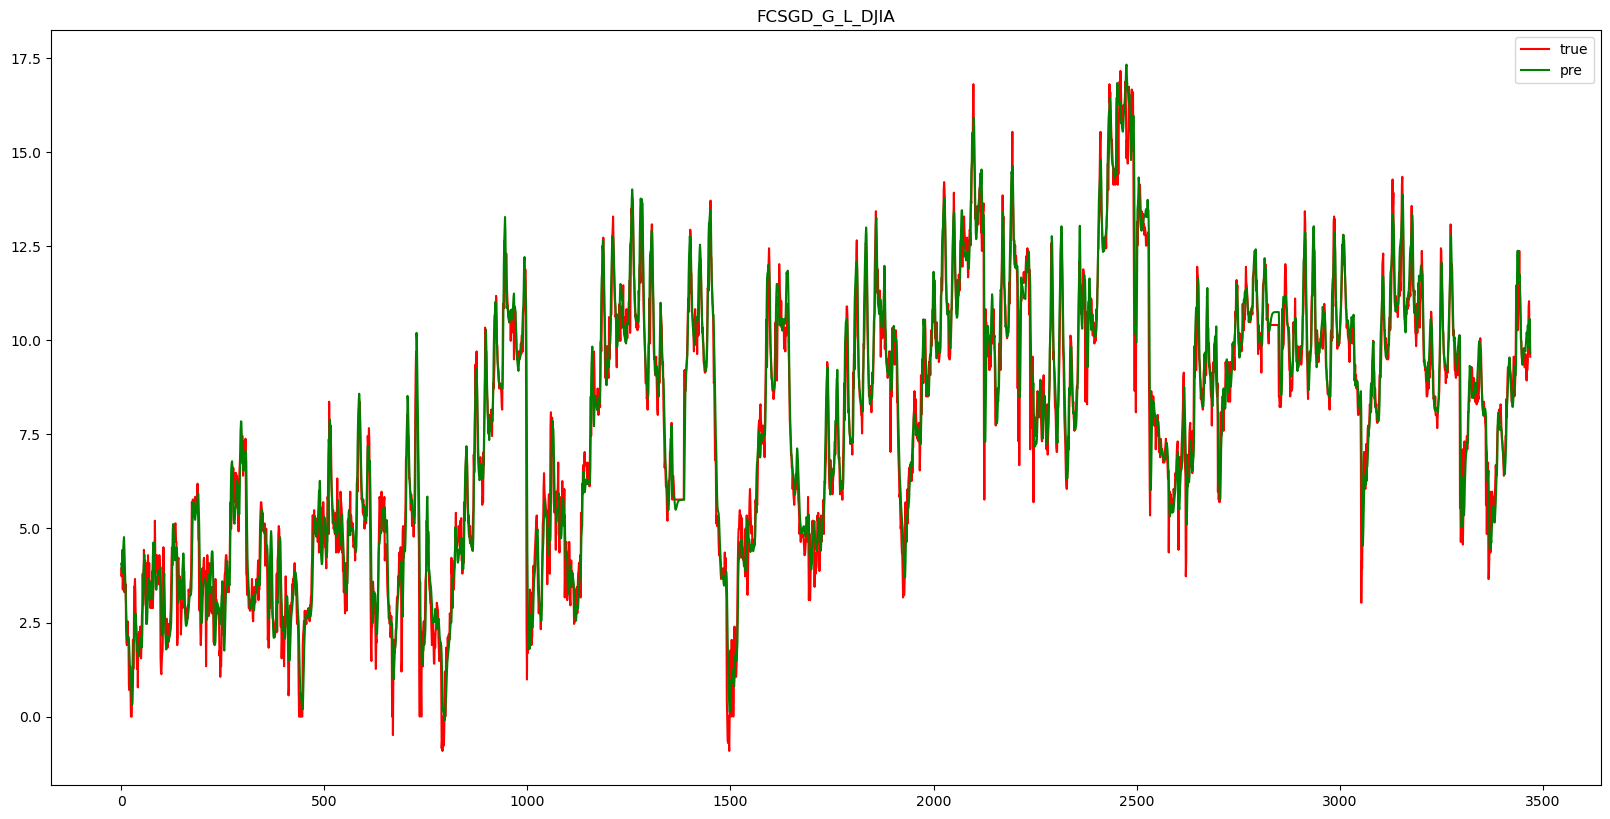

In [525]:
y_true = scaler.inverse_transform(y_test.cpu().detach().numpy())
y_pre = scaler.inverse_transform(hn_1.cpu().detach().numpy())
plt.figure(figsize=(20, 10),dpi=100)
plt.title('FCSGD_G_L_DJIA')
plt.plot(y_true,color='red',label='true')
plt.plot(y_pre,color='green',label='pre')
plt.legend()
plt.show()

In [43]:
#DJIA train and test
epoch = 250
batch_size = 256
model = Net()
model.to(device)
criterion = nn.MSELoss()

#choose optimizers
optimizer = FCSGD_G_L(model.parameters(),lr=0.01,weight_decay=0,r=-0.1)
#optimizer = FCAdam_G_L(model.parameters(),lr=0.0001,weight_decay=0,r=0.0)
#optimizer = torch.optim.Adam(model.parameters(),lr=0.0001,weight_decay=0)
A_01 = []
timestart = time.time()
for i in range(epoch):
    if 50<=i<100:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.005
    if 100<=i<150:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.001
    if 150<=i<200:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0005
    if 200<=i:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0001
    loss_sum = 0
    start = np.random.randint(11,size=1)[0]  #Generate a random integer between 0 and 10
    while start+batch_size<len(X_train):
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        start = start+batch_size
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        out,hn = model(X_batch)
        loss = criterion(hn,y_batch)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum +=loss
    A_01.append(loss_sum.cpu().detach().numpy())
    print('epoch:{0},loss:{1}'.format(i,loss_sum.cpu().detach().numpy()))
#torch.save(model.state_dict(), "lstm_best.pth")
timeend = time.time()
spend_time = timeend-timestart
print(spend_time)

epoch:0,loss:6.183669567108154
epoch:1,loss:9.347463607788086
epoch:2,loss:9.295007705688477
epoch:3,loss:9.005171775817871
epoch:4,loss:9.254142761230469
epoch:5,loss:9.053827285766602
epoch:6,loss:9.195952415466309
epoch:7,loss:9.407917022705078
epoch:8,loss:9.01563835144043
epoch:9,loss:9.26674747467041
epoch:10,loss:9.223732948303223
epoch:11,loss:9.136088371276855
epoch:12,loss:9.04159164428711
epoch:13,loss:9.197271347045898
epoch:14,loss:9.114385604858398
epoch:15,loss:9.125975608825684
epoch:16,loss:9.011674880981445
epoch:17,loss:8.802966117858887
epoch:18,loss:8.937252044677734
epoch:19,loss:8.868917465209961
epoch:20,loss:8.510953903198242
epoch:21,loss:8.23381233215332
epoch:22,loss:8.039250373840332
epoch:23,loss:7.553537368774414
epoch:24,loss:6.468869209289551
epoch:25,loss:5.208462715148926
epoch:26,loss:3.1194090843200684
epoch:27,loss:1.292136311531067
epoch:28,loss:0.3780571222305298
epoch:29,loss:0.14091911911964417
epoch:30,loss:0.11775578558444977
epoch:31,loss:0.

epoch:240,loss:0.08274811506271362
epoch:241,loss:0.08555437624454498
epoch:242,loss:0.0841752365231514
epoch:243,loss:0.0842977911233902
epoch:244,loss:0.08336314558982849
epoch:245,loss:0.08268392831087112
epoch:246,loss:0.08474146574735641
epoch:247,loss:0.08583220839500427
epoch:248,loss:0.08405651897192001
epoch:249,loss:0.08606106042861938
132.32291626930237


In [44]:
#DJIA train and test
epoch = 250
batch_size = 256
model = Net()
model.to(device)
criterion = nn.MSELoss()

#choose optimizers
optimizer = FCSGD_G_L(model.parameters(),lr=0.01,weight_decay=0,r=0.0)
#optimizer = FCAdam_G_L(model.parameters(),lr=0.0001,weight_decay=0,r=0.0)
#optimizer = torch.optim.Adam(model.parameters(),lr=0.0001,weight_decay=0)
A_0 = []
timestart = time.time()
for i in range(epoch):
    if 50<=i<100:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.005
    if 100<=i<150:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.001
    if 150<=i<200:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0005
    if 200<=i:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0001
    loss_sum = 0
    start = np.random.randint(11,size=1)[0]  #Generate a random integer between 0 and 10
    while start+batch_size<len(X_train):
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        start = start+batch_size
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        out,hn = model(X_batch)
        loss = criterion(hn,y_batch)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum +=loss
    A_0.append(loss_sum.cpu().detach().numpy())
    print('epoch:{0},loss:{1}'.format(i,loss_sum.cpu().detach().numpy()))
torch.save(model.state_dict(), "lstm_best.pth")
timeend = time.time()
spend_time = timeend-timestart
print(spend_time)

epoch:0,loss:7.077115535736084
epoch:1,loss:8.944389343261719
epoch:2,loss:9.31717300415039
epoch:3,loss:8.90140151977539
epoch:4,loss:8.967309951782227
epoch:5,loss:9.137767791748047
epoch:6,loss:9.04249382019043
epoch:7,loss:9.132683753967285
epoch:8,loss:9.233480453491211
epoch:9,loss:9.106141090393066
epoch:10,loss:9.064539909362793
epoch:11,loss:9.029864311218262
epoch:12,loss:9.044081687927246
epoch:13,loss:8.936009407043457
epoch:14,loss:9.131607055664062
epoch:15,loss:8.785968780517578
epoch:16,loss:9.0596923828125
epoch:17,loss:8.873587608337402
epoch:18,loss:8.938720703125
epoch:19,loss:8.985445022583008
epoch:20,loss:8.962925910949707
epoch:21,loss:8.79126262664795
epoch:22,loss:8.74826431274414
epoch:23,loss:8.99976921081543
epoch:24,loss:8.803832054138184
epoch:25,loss:8.626495361328125
epoch:26,loss:8.630770683288574
epoch:27,loss:8.287437438964844
epoch:28,loss:8.2446928024292
epoch:29,loss:7.650803565979004
epoch:30,loss:7.252721786499023
epoch:31,loss:6.233832836151123

epoch:241,loss:0.09132401645183563
epoch:242,loss:0.09235842525959015
epoch:243,loss:0.09256187081336975
epoch:244,loss:0.09169872105121613
epoch:245,loss:0.09116025269031525
epoch:246,loss:0.09076259285211563
epoch:247,loss:0.0930686891078949
epoch:248,loss:0.09145921468734741
epoch:249,loss:0.09168045967817307
132.08986401557922


In [45]:
#DJIA train and test
epoch = 250
batch_size = 256
model = Net()
model.to(device)
criterion = nn.MSELoss()

#choose optimizers
optimizer = FCSGD_G_L(model.parameters(),lr=0.01,weight_decay=0,r=0.1)
#optimizer = FCAdam_G_L(model.parameters(),lr=0.0001,weight_decay=0,r=0.0)
#optimizer = torch.optim.Adam(model.parameters(),lr=0.0001,weight_decay=0)
A_1 = []
timestart = time.time()
for i in range(epoch):
    if 50<=i<100:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.005
    if 100<=i<150:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.001
    if 150<=i<200:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0005
    if 200<=i:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0001
    loss_sum = 0
    start = np.random.randint(11,size=1)[0]  #Generate a random integer between 0 and 10
    while start+batch_size<len(X_train):
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        start = start+batch_size
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        out,hn = model(X_batch)
        loss = criterion(hn,y_batch)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum +=loss
    A_1.append(loss_sum.cpu().detach().numpy())
    print('epoch:{0},loss:{1}'.format(i,loss_sum.cpu().detach().numpy()))
#torch.save(model.state_dict(), "lstm_best.pth")
timeend = time.time()
spend_time = timeend-timestart
print(spend_time)

epoch:0,loss:7.260022163391113
epoch:1,loss:8.727043151855469
epoch:2,loss:8.770713806152344
epoch:3,loss:8.71929931640625
epoch:4,loss:8.77464771270752
epoch:5,loss:8.694705963134766
epoch:6,loss:8.865756034851074
epoch:7,loss:8.683932304382324
epoch:8,loss:8.705022811889648
epoch:9,loss:8.586874008178711
epoch:10,loss:8.690967559814453
epoch:11,loss:8.706411361694336
epoch:12,loss:8.725045204162598
epoch:13,loss:8.617685317993164
epoch:14,loss:8.535529136657715
epoch:15,loss:8.465255737304688
epoch:16,loss:8.317142486572266
epoch:17,loss:8.084232330322266
epoch:18,loss:8.137304306030273
epoch:19,loss:7.680964469909668
epoch:20,loss:7.434257507324219
epoch:21,loss:7.077854633331299
epoch:22,loss:6.538632392883301
epoch:23,loss:5.62237024307251
epoch:24,loss:4.240008354187012
epoch:25,loss:2.6678144931793213
epoch:26,loss:1.3162232637405396
epoch:27,loss:0.5250030755996704
epoch:28,loss:0.20759697258472443
epoch:29,loss:0.1315276026725769
epoch:30,loss:0.1213759034872055
epoch:31,loss:

epoch:240,loss:0.0838932991027832
epoch:241,loss:0.08279120177030563
epoch:242,loss:0.08482770621776581
epoch:243,loss:0.0817473903298378
epoch:244,loss:0.08433689177036285
epoch:245,loss:0.08391401916742325
epoch:246,loss:0.08344106376171112
epoch:247,loss:0.0835050716996193
epoch:248,loss:0.0842202678322792
epoch:249,loss:0.08287843316793442
131.9038212299347


In [46]:
#DJIA train and test
epoch = 250
batch_size = 256
model = Net()
model.to(device)
criterion = nn.MSELoss()

#choose optimizers
optimizer = FCSGD_G_L(model.parameters(),lr=0.01,weight_decay=0,r=0.2)
#optimizer = FCAdam_G_L(model.parameters(),lr=0.0001,weight_decay=0,r=0.0)
#optimizer = torch.optim.Adam(model.parameters(),lr=0.0001,weight_decay=0)
A_2 = []
timestart = time.time()
for i in range(epoch):
    if 50<=i<100:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.005
    if 100<=i<150:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.001
    if 150<=i<200:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0005
    if 200<=i:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0001
    loss_sum = 0
    start = np.random.randint(11,size=1)[0]  #Generate a random integer between 0 and 10
    while start+batch_size<len(X_train):
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        start = start+batch_size
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        out,hn = model(X_batch)
        loss = criterion(hn,y_batch)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum +=loss
    A_2.append(loss_sum.cpu().detach().numpy())
    print('epoch:{0},loss:{1}'.format(i,loss_sum.cpu().detach().numpy()))
#torch.save(model.state_dict(), "lstm_best.pth")
timeend = time.time()
spend_time = timeend-timestart
print(spend_time)

epoch:0,loss:9.588178634643555
epoch:1,loss:8.568846702575684
epoch:2,loss:8.58899211883545
epoch:3,loss:8.624127388000488
epoch:4,loss:8.555632591247559
epoch:5,loss:8.682391166687012
epoch:6,loss:8.530635833740234
epoch:7,loss:8.701218605041504
epoch:8,loss:8.595507621765137
epoch:9,loss:8.57546329498291
epoch:10,loss:8.566861152648926
epoch:11,loss:8.439871788024902
epoch:12,loss:8.443560600280762
epoch:13,loss:8.484823226928711
epoch:14,loss:8.4052095413208
epoch:15,loss:8.363468170166016
epoch:16,loss:8.214094161987305
epoch:17,loss:7.986191272735596
epoch:18,loss:7.945337295532227
epoch:19,loss:7.693864822387695
epoch:20,loss:7.374962329864502
epoch:21,loss:6.946593761444092
epoch:22,loss:6.220057487487793
epoch:23,loss:5.243039131164551
epoch:24,loss:3.944840908050537
epoch:25,loss:2.3672561645507812
epoch:26,loss:1.115251064300537
epoch:27,loss:0.40430015325546265
epoch:28,loss:0.1635308414697647
epoch:29,loss:0.11642485857009888
epoch:30,loss:0.10770870000123978
epoch:31,loss:

epoch:241,loss:0.0850161761045456
epoch:242,loss:0.0844835638999939
epoch:243,loss:0.08336174488067627
epoch:244,loss:0.0837511196732521
epoch:245,loss:0.08400259912014008
epoch:246,loss:0.08427277207374573
epoch:247,loss:0.08603230118751526
epoch:248,loss:0.08490858227014542
epoch:249,loss:0.08304638415575027
133.23012018203735


In [31]:
#DJIA train and test
epoch = 250
batch_size = 256
model = Net()
model.to(device)
criterion = nn.MSELoss()

#choose optimizers
optimizer = FCSGD_G_L(model.parameters(),lr=0.01,weight_decay=0,r=1)
#optimizer = FCAdam_G_L(model.parameters(),lr=0.0001,weight_decay=0,r=0.0)
A_SGD = []
timestart = time.time()
for i in range(epoch):
    if 50<=i<100:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.005
    if 100<=i<150:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.001
    if 150<=i<200:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0005
    if 200<=i:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0001
    loss_sum = 0
    start = np.random.randint(11,size=1)[0]  #Generate a random integer between 0 and 10
    while start+batch_size<len(X_train):
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        start = start+batch_size
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        out,hn = model(X_batch)
        loss = criterion(hn,y_batch)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum +=loss
    A_SGD.append(loss_sum.cpu().detach().numpy())
    print('epoch:{0},loss:{1}'.format(i,loss_sum.cpu().detach().numpy()))
torch.save(model.state_dict(), "lstm_best.pth")
timeend = time.time()
spend_time = timeend-timestart
print(spend_time)

epoch:0,loss:11.23331356048584
epoch:1,loss:8.391785621643066
epoch:2,loss:8.235899925231934
epoch:3,loss:8.205705642700195
epoch:4,loss:8.174551010131836
epoch:5,loss:8.15692138671875
epoch:6,loss:8.135498046875
epoch:7,loss:8.12814712524414
epoch:8,loss:8.102568626403809
epoch:9,loss:8.084344863891602
epoch:10,loss:8.05044937133789
epoch:11,loss:8.02478313446045
epoch:12,loss:8.008716583251953
epoch:13,loss:7.980694770812988
epoch:14,loss:7.94502592086792
epoch:15,loss:7.899095058441162
epoch:16,loss:7.850878715515137
epoch:17,loss:7.807949542999268
epoch:18,loss:7.748560905456543
epoch:19,loss:7.6769280433654785
epoch:20,loss:7.618867874145508
epoch:21,loss:7.5491623878479
epoch:22,loss:7.453078746795654
epoch:23,loss:7.343023300170898
epoch:24,loss:7.218843460083008
epoch:25,loss:7.0692315101623535
epoch:26,loss:6.888874530792236
epoch:27,loss:6.676131725311279
epoch:28,loss:6.431511878967285
epoch:29,loss:6.121208190917969
epoch:30,loss:5.744259357452393
epoch:31,loss:5.2858109474

epoch:241,loss:0.10895140469074249
epoch:242,loss:0.1077675074338913
epoch:243,loss:0.10751983523368835
epoch:244,loss:0.10923948884010315
epoch:245,loss:0.10891345143318176
epoch:246,loss:0.10733592510223389
epoch:247,loss:0.11091083288192749
epoch:248,loss:0.10816709697246552
epoch:249,loss:0.10973885655403137
136.30707573890686


In [32]:
#DJIA train and test
epoch = 250
batch_size = 256
model = Net()
model.to(device)
criterion = nn.MSELoss()

#choose optimizers
#optimizer = FCSGD_G_L(model.parameters(),lr=0.01,weight_decay=0,r=1)
#optimizer = FCAdam_G_L(model.parameters(),lr=0.0001,weight_decay=0,r=0.0)
optimizer = torch.optim.SGD(model.parameters(),lr=0.01,weight_decay=0,momentum=0.9)
A_SGDM = []
timestart = time.time()
for i in range(epoch):
    if 50<=i<100:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.005
    if 100<=i<150:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.001
    if 150<=i<200:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0005
    if 200<=i:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0001
    loss_sum = 0
    start = np.random.randint(11,size=1)[0]  #Generate a random integer between 0 and 10
    while start+batch_size<len(X_train):
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        start = start+batch_size
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        out,hn = model(X_batch)
        loss = criterion(hn,y_batch)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum +=loss
    A_SGDM.append(loss_sum.cpu().detach().numpy())
    print('epoch:{0},loss:{1}'.format(i,loss_sum.cpu().detach().numpy()))
torch.save(model.state_dict(), "lstm_best.pth")
timeend = time.time()
spend_time = timeend-timestart
print(spend_time)

epoch:0,loss:6.105081558227539
epoch:1,loss:14.1432523727417
epoch:2,loss:12.899704933166504
epoch:3,loss:12.552431106567383
epoch:4,loss:12.514520645141602
epoch:5,loss:12.472799301147461
epoch:6,loss:12.441802978515625
epoch:7,loss:12.50024700164795
epoch:8,loss:12.499110221862793
epoch:9,loss:12.56521224975586
epoch:10,loss:12.581131935119629
epoch:11,loss:12.59228229522705
epoch:12,loss:12.554726600646973
epoch:13,loss:12.554668426513672
epoch:14,loss:12.536497116088867
epoch:15,loss:12.538968086242676
epoch:16,loss:12.53530502319336
epoch:17,loss:12.584770202636719
epoch:18,loss:12.564170837402344
epoch:19,loss:12.537793159484863
epoch:20,loss:12.53796100616455
epoch:21,loss:12.52950668334961
epoch:22,loss:12.532771110534668
epoch:23,loss:12.515501022338867
epoch:24,loss:12.520549774169922
epoch:25,loss:12.49647045135498
epoch:26,loss:12.485387802124023
epoch:27,loss:12.533567428588867
epoch:28,loss:12.521313667297363
epoch:29,loss:12.499303817749023
epoch:30,loss:12.4941663742065

epoch:243,loss:0.11573107540607452
epoch:244,loss:0.11491090059280396
epoch:245,loss:0.11665427684783936
epoch:246,loss:0.1173524484038353
epoch:247,loss:0.11648479104042053
epoch:248,loss:0.11765087395906448
epoch:249,loss:0.1174359917640686
103.25636839866638


In [26]:
#DJIA train and test
epoch = 250
batch_size = 256
model = Net()
model.to(device)
criterion = nn.MSELoss()

#choose optimizers
optimizer = FCSGD_G_L(model.parameters(),lr=0.01,weight_decay=0,r=0.3)
#optimizer = FCAdam_G_L(model.parameters(),lr=0.0001,weight_decay=0,r=0.3)
#optimizer = torch.optim.Adam(model.parameters(),lr=0.0001,weight_decay=0)
A_3 = []
timestart = time.time()
for i in range(epoch):
    if 50<=i<100:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.005
    if 100<=i<150:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.001
    if 150<=i<200:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0005
    if 200<=i:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0001
    loss_sum = 0
    start = np.random.randint(11,size=1)[0]  #Generate a random integer between 0 and 10
    while start+batch_size<len(X_train):
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        start = start+batch_size
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        out,hn = model(X_batch)
        loss = criterion(hn,y_batch)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum +=loss
    A_3.append(loss_sum.cpu().detach().numpy())
    print('epoch:{0},loss:{1}'.format(i,loss_sum.cpu().detach().numpy()))
torch.save(model.state_dict(), "lstm_best.pth")
timeend = time.time()
spend_time = timeend-timestart
print(spend_time)

epoch:0,loss:9.226849555969238
epoch:1,loss:8.382146835327148
epoch:2,loss:8.542112350463867
epoch:3,loss:8.544939041137695
epoch:4,loss:8.501047134399414
epoch:5,loss:8.492449760437012
epoch:6,loss:8.3988618850708
epoch:7,loss:8.365592002868652
epoch:8,loss:8.378538131713867
epoch:9,loss:8.459305763244629
epoch:10,loss:8.369500160217285
epoch:11,loss:8.204333305358887
epoch:12,loss:8.208537101745605
epoch:13,loss:8.054316520690918
epoch:14,loss:8.03396224975586
epoch:15,loss:7.768827438354492
epoch:16,loss:7.666451930999756
epoch:17,loss:7.3993754386901855
epoch:18,loss:7.132462978363037
epoch:19,loss:6.51241397857666
epoch:20,loss:5.978292942047119
epoch:21,loss:5.014145374298096
epoch:22,loss:3.7277300357818604
epoch:23,loss:2.4921629428863525
epoch:24,loss:1.3861083984375
epoch:25,loss:0.6771413087844849
epoch:26,loss:0.351309210062027
epoch:27,loss:0.22561202943325043
epoch:28,loss:0.18524684011936188
epoch:29,loss:0.17049917578697205
epoch:30,loss:0.16102701425552368
epoch:31,los

epoch:240,loss:0.10109800100326538
epoch:241,loss:0.10209035873413086
epoch:242,loss:0.09903690218925476
epoch:243,loss:0.10051871836185455
epoch:244,loss:0.10216337442398071
epoch:245,loss:0.10240985453128815
epoch:246,loss:0.10293460637331009
epoch:247,loss:0.09684838354587555
epoch:248,loss:0.10199232399463654
epoch:249,loss:0.10409452021121979
133.95692229270935


In [27]:
#DJIA train and test
epoch = 250
batch_size = 256
model = Net()
model.to(device)
criterion = nn.MSELoss()

#choose optimizers
optimizer = FCSGD_G_L(model.parameters(),lr=0.01,weight_decay=0,r=0.4)
#optimizer = FCAdam_G_L(model.parameters(),lr=0.0001,weight_decay=0,r=0.4)
#optimizer = torch.optim.Adam(model.parameters(),lr=0.0001,weight_decay=0)
A_4 = []
timestart = time.time()
for i in range(epoch):
    if 50<=i<100:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.005
    if 100<=i<150:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.001
    if 150<=i<200:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0005
    if 200<=i:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0001
    loss_sum = 0
    start = np.random.randint(11,size=1)[0]  #Generate a random integer between 0 and 10
    while start+batch_size<len(X_train):
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        start = start+batch_size
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        out,hn = model(X_batch)
        loss = criterion(hn,y_batch)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum +=loss
    A_4.append(loss_sum.cpu().detach().numpy())
    print('epoch:{0},loss:{1}'.format(i,loss_sum.cpu().detach().numpy()))
torch.save(model.state_dict(), "lstm_best.pth")
timeend = time.time()
spend_time = timeend-timestart
print(spend_time)

epoch:0,loss:8.736479759216309
epoch:1,loss:8.46987533569336
epoch:2,loss:8.616263389587402
epoch:3,loss:8.466793060302734
epoch:4,loss:8.48441219329834
epoch:5,loss:8.467724800109863
epoch:6,loss:8.564983367919922
epoch:7,loss:8.279257774353027
epoch:8,loss:8.495452880859375
epoch:9,loss:8.280228614807129
epoch:10,loss:8.324726104736328
epoch:11,loss:8.216310501098633
epoch:12,loss:8.141057968139648
epoch:13,loss:8.12177562713623
epoch:14,loss:8.001277923583984
epoch:15,loss:8.01274299621582
epoch:16,loss:7.921711444854736
epoch:17,loss:7.810619831085205
epoch:18,loss:7.563051700592041
epoch:19,loss:7.334878921508789
epoch:20,loss:7.054834842681885
epoch:21,loss:6.599778175354004
epoch:22,loss:5.9568705558776855
epoch:23,loss:5.158764839172363
epoch:24,loss:4.173576354980469
epoch:25,loss:2.9127960205078125
epoch:26,loss:1.74774169921875
epoch:27,loss:0.8842518329620361
epoch:28,loss:0.4200030267238617
epoch:29,loss:0.22895213961601257
epoch:30,loss:0.1619960367679596
epoch:31,loss:0.

epoch:241,loss:0.10684908181428909
epoch:242,loss:0.10641966760158539
epoch:243,loss:0.10687533020973206
epoch:244,loss:0.1061445027589798
epoch:245,loss:0.10602111369371414
epoch:246,loss:0.10892379283905029
epoch:247,loss:0.10736336559057236
epoch:248,loss:0.10819624364376068
epoch:249,loss:0.10696735978126526
135.60015225410461


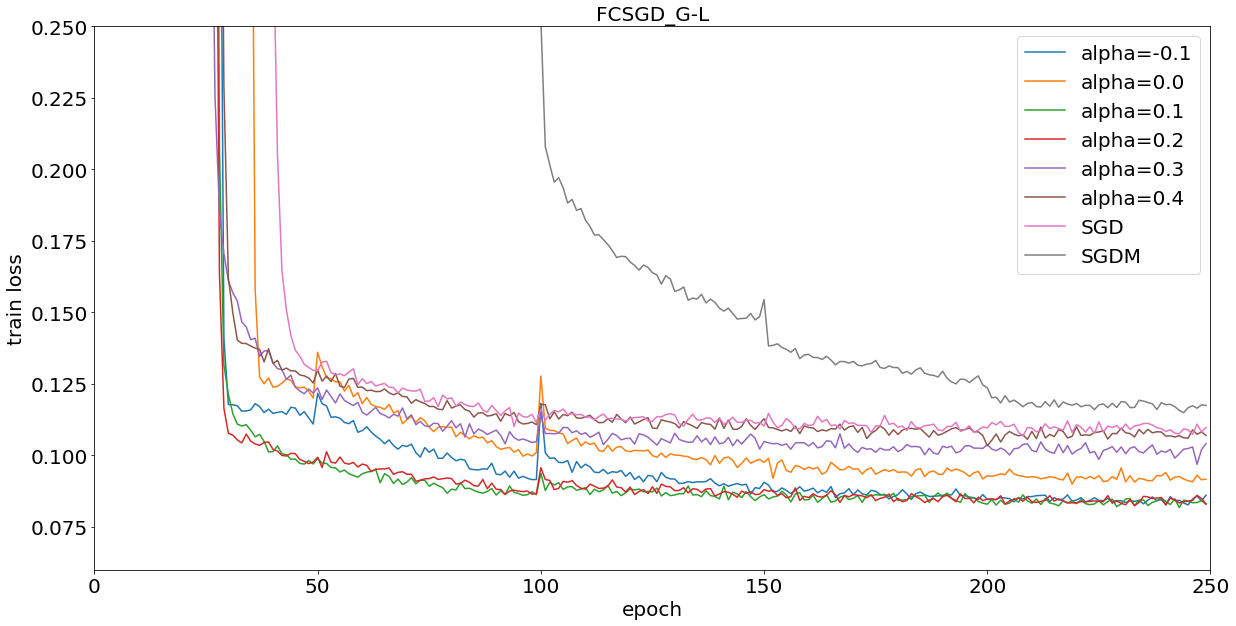

In [47]:
plt.figure(figsize=(20, 10))
plt.plot(A_01,label='alpha=-0.1')
plt.plot(A_0,label='alpha=0.0')
plt.plot(A_1,label='alpha=0.1')
plt.plot(A_2,label='alpha=0.2')
plt.plot(A_3,label='alpha=0.3')
plt.plot(A_4,label='alpha=0.4')
plt.plot(A_SGD,label='SGD')
plt.plot(A_SGDM,label='SGDM')
#plt.plot(A,label='Adam')
plt.ylim(0.06,0.25)
plt.xlim(0,250)
plt.legend(fontsize=20)
plt.tick_params(axis='both',which='major',labelsize=20)
plt.xlabel('epoch', fontsize=20)
plt.ylabel('train loss', fontsize=20)
plt.title('FCSGD_G-L', fontsize=20)
plt.show()

In [564]:
#DJIA train and test
epoch = 250
batch_size = 256
model = Net()
model.to(device)
criterion = nn.MSELoss()

#choose optimizers
#optimizer = FCSGD_G_L(model.parameters(),lr=0.01,weight_decay=0,r=-0.4)
#optimizer = FCAdam_G_L(model.parameters(),lr=0.0001,weight_decay=0,r=0.9)
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001,weight_decay=0)
A = []
timestart = time.time()
for i in range(epoch):
    if 50<=i<100:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.00005
    if 100<=i<150:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.00001
    if 150<=i<200:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.000005
    if 200<=i<250:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.000001
    loss_sum = 0
    start = np.random.randint(11,size=1)[0]  #Generate a random integer between 0 and 10
    while start+batch_size<len(X_train):
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        start = start+batch_size
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        out,hn = model(X_batch)
        loss = criterion(hn,y_batch)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum +=loss
    A.append(loss_sum.cpu().detach().numpy())
    print('epoch:{0},loss:{1}'.format(i,loss_sum.cpu().detach().numpy()))
torch.save(model.state_dict(), "lstm_best.pth")
timeend = time.time()
spend_time = timeend-timestart
print(spend_time)

epoch:0,loss:19.815353393554688
epoch:1,loss:7.487786293029785
epoch:2,loss:5.115107536315918
epoch:3,loss:3.5166215896606445
epoch:4,loss:2.375791311264038
epoch:5,loss:1.458635687828064
epoch:6,loss:0.6449244022369385
epoch:7,loss:0.20479828119277954
epoch:8,loss:0.1625911444425583
epoch:9,loss:0.18987014889717102
epoch:10,loss:0.2074122279882431
epoch:11,loss:0.21195031702518463
epoch:12,loss:0.20520968735218048
epoch:13,loss:0.2309478372335434
epoch:14,loss:0.23300819098949432
epoch:15,loss:0.36145055294036865
epoch:16,loss:0.2679610550403595
epoch:17,loss:0.38362744450569153
epoch:18,loss:0.2241218090057373
epoch:19,loss:0.24376651644706726
epoch:20,loss:0.197641059756279
epoch:21,loss:0.2200956642627716
epoch:22,loss:0.19112645089626312
epoch:23,loss:0.21981211006641388
epoch:24,loss:0.19533595442771912
epoch:25,loss:0.2279435098171234
epoch:26,loss:0.19892294704914093
epoch:27,loss:0.22847343981266022
epoch:28,loss:0.1965017020702362
epoch:29,loss:0.2255905568599701
epoch:30,los

epoch:238,loss:0.02731570601463318
epoch:239,loss:0.027417700737714767
epoch:240,loss:0.02750786766409874
epoch:241,loss:0.027236755937337875
epoch:242,loss:0.02721581421792507
epoch:243,loss:0.027875982224941254
epoch:244,loss:0.027347182855010033
epoch:245,loss:0.027911584824323654
epoch:246,loss:0.027597248554229736
epoch:247,loss:0.02720639295876026
epoch:248,loss:0.027385102584958076
epoch:249,loss:0.027396032586693764
111.70310544967651


In [400]:
#DJIA train and test
epoch = 250
batch_size = 256
model = Net()
model.to(device)
criterion = nn.MSELoss()

#choose optimizers
#optimizer = FCSGD_G_L(model.parameters(),lr=0.01,weight_decay=0,r=-0.4)
optimizer = FCAdam_G_L(model.parameters(),lr=0.0001,weight_decay=0,r=0.2)
#optimizer = torch.optim.Adam(model.parameters(),lr=0.0001,weight_decay=0)
A_r = []
timestart = time.time()
for i in range(epoch):
    if 50<=i<100:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.00005
    if 100<=i<150:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.00001
    if 150<=i<200:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.000005
    if 200<=i<250:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.000001
    loss_sum = 0
    start = np.random.randint(11,size=1)[0]  #Generate a random integer between 0 and 10
    while start+batch_size<len(X_train):
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        start = start+batch_size
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        out,hn = model(X_batch)
        loss = criterion(hn,y_batch)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum +=loss
    A_r.append(loss_sum.cpu().detach().numpy())
    print('epoch:{0},loss:{1}'.format(i,loss_sum.cpu().detach().numpy()))
torch.save(model.state_dict(), "lstm_best.pth")
timeend = time.time()
spend_time = timeend-timestart
print(spend_time)

epoch:0,loss:11.817750930786133
epoch:1,loss:8.042681694030762
epoch:2,loss:6.465827941894531
epoch:3,loss:5.055267810821533
epoch:4,loss:3.397780179977417
epoch:5,loss:0.7861583232879639
epoch:6,loss:1.9230024814605713
epoch:7,loss:2.362980365753174
epoch:8,loss:0.8303384780883789
epoch:9,loss:0.28248944878578186
epoch:10,loss:0.28674978017807007
epoch:11,loss:0.2777950167655945
epoch:12,loss:0.26580673456192017
epoch:13,loss:0.26010024547576904
epoch:14,loss:0.252459853887558
epoch:15,loss:0.2455807775259018
epoch:16,loss:0.2399744689464569
epoch:17,loss:0.2347806990146637
epoch:18,loss:0.2290460616350174
epoch:19,loss:0.22382128238677979
epoch:20,loss:0.22079192101955414
epoch:21,loss:0.21403810381889343
epoch:22,loss:0.21283303201198578
epoch:23,loss:0.2056153118610382
epoch:24,loss:0.22170574963092804
epoch:25,loss:0.24830299615859985
epoch:26,loss:0.5367225408554077
epoch:27,loss:0.838360071182251
epoch:28,loss:1.8415088653564453
epoch:29,loss:0.3154093027114868
epoch:30,loss:0.2

epoch:237,loss:0.02447453886270523
epoch:238,loss:0.024830389767885208
epoch:239,loss:0.023306313902139664
epoch:240,loss:0.023507919162511826
epoch:241,loss:0.024477537721395493
epoch:242,loss:0.02454645000398159
epoch:243,loss:0.024386318400502205
epoch:244,loss:0.023572184145450592
epoch:245,loss:0.023853860795497894
epoch:246,loss:0.02376823127269745
epoch:247,loss:0.023746710270643234
epoch:248,loss:0.024039477109909058
epoch:249,loss:0.023470917716622353
163.70779371261597


In [6]:
#ETTm2 data preprocessing
slide_windows_size = 72  #there are 72 steps a day in total
pre_minutes = 1
df_ETTm2 = pd.read_csv('.\ETTh1.csv')
del df_ETTm2['date']
df_ETTm2['label'] = df_ETTm2['OT'].shift(-pre_minutes)
df_ETTm2.dropna()
scaler = StandardScaler()
sca_X_ETTm2 = scaler.fit_transform(df_ETTm2.iloc[:,:-1])
deq_ETTm2 = deque(maxlen=slide_windows_size)
X_ETTm2 = []
for i in sca_X_ETTm2:
    deq_ETTm2.append(list(i))
    if len(deq_ETTm2)==slide_windows_size:
        X_ETTm2.append(list(deq_ETTm2))
X_ETTm2 = X_ETTm2[:-pre_minutes]
y_ETTm2 = scaler.fit_transform(pd.DataFrame(df_ETTm2['label'].values[slide_windows_size-1:-pre_minutes]))
X_ETTm2, y_ETTm2 = torch.Tensor(X_ETTm2),torch.Tensor(y_ETTm2)
#X_DJIA, y_DJIA = X_DJIA.to(device), y_DJIA.to(device)
X_train,X_test,y_train,y_test = train_test_split(X_ETTm2,y_ETTm2,test_size=0.2,shuffle=False)

In [498]:
#ETTm2 network model
class Net(nn.Module):
    def __init__(self,):
        super(Net,self).__init__()
        self.rnn = nn.LSTM(
            input_size=7,
            hidden_size=64,
            num_layers=3,
            dropout=0.2,
            batch_first=True
        )
        self.linear_1 = nn.Linear(64,32)
        self.linear_2 = nn.Linear(32,1)
    
    def forward(self,x):
        out,(hn,cn) = self.rnn(x)
        hn = self.linear_1(hn[2])
        hn = self.linear_2(hn)
        hn = hn.view(-1,1)
        return out,hn

In [8]:
#ETTm2 train and test
epoch = 250
batch_size = 256
model = Net()
model.to(device)
criterion = nn.MSELoss()

#choose optimizers
optimizer = FCSGD_G_L(model.parameters(),lr=0.01,weight_decay=0,r=-0.1)
#optimizer = FCAdam_G_L(model.parameters(),lr=0.0001,weight_decay=0,r=-0.1)
#optimizer = torch.optim.Adam(model.parameters(),lr=0.0001,weight_decay=0)
E_01 = []
timestart = time.time()
for i in range(epoch):
    if 50<=i<100:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.005
    if 100<=i<150:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.001
    if 150<=i<200:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0005
    if 200<=i<250:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0001
    loss_sum = 0
    start = np.random.randint(11,size=1)[0]  #Generate a random integer between 0 and 10
    while start+batch_size<len(X_train):
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        start = start+batch_size
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        out,hn = model(X_batch)
        loss = criterion(hn,y_batch)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum +=loss
    E_01.append(loss_sum.cpu().detach().numpy())
    print('epoch:{0},loss:{1}'.format(i,loss_sum.cpu().detach().numpy()))
torch.save(model.state_dict(), "lstm_best.pth")
timeend = time.time()
spend_time = timeend-timestart
print(spend_time)

C:\Users\zxj\AppData\Local\Temp\ipykernel_13712\805980781.py:76: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\python_arg_parser.cpp:1055.)
  fractional_order_grad.add_(1,grad.clone())\


epoch:0,loss:66.36431121826172
epoch:1,loss:70.5276107788086
epoch:2,loss:69.5512924194336
epoch:3,loss:69.03926086425781
epoch:4,loss:68.56442260742188
epoch:5,loss:69.0693588256836
epoch:6,loss:69.17940521240234
epoch:7,loss:68.20589447021484
epoch:8,loss:66.51969909667969
epoch:9,loss:54.944427490234375
epoch:10,loss:20.859333038330078
epoch:11,loss:8.347086906433105
epoch:12,loss:5.680901527404785
epoch:13,loss:4.706480503082275
epoch:14,loss:4.232199668884277
epoch:15,loss:3.8089587688446045
epoch:16,loss:3.4447882175445557
epoch:17,loss:3.198622465133667
epoch:18,loss:2.8836400508880615
epoch:19,loss:2.7576701641082764
epoch:20,loss:2.6185686588287354
epoch:21,loss:2.489041566848755
epoch:22,loss:2.369835376739502
epoch:23,loss:2.313842296600342
epoch:24,loss:2.2421395778656006
epoch:25,loss:2.220982313156128
epoch:26,loss:2.190309762954712
epoch:27,loss:2.135394334793091
epoch:28,loss:2.107023000717163
epoch:29,loss:2.104424476623535
epoch:30,loss:2.0107243061065674
epoch:31,los

epoch:247,loss:1.3993364572525024
epoch:248,loss:1.3987441062927246
epoch:249,loss:1.4107649326324463
153.00397300720215


In [9]:
#ETTm2 train and test
epoch = 250
batch_size = 256
model = Net()
model.to(device)
criterion = nn.MSELoss()

#choose optimizers
optimizer = FCSGD_G_L(model.parameters(),lr=0.01,weight_decay=0,r=0.0)
#optimizer = FCAdam_G_L(model.parameters(),lr=0.0001,weight_decay=0,r=-0.1)
#optimizer = torch.optim.Adam(model.parameters(),lr=0.0001,weight_decay=0)
E_0 = []
timestart = time.time()
for i in range(epoch):
    if 50<=i<100:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.005
    if 100<=i<150:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.001
    if 150<=i<200:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0005
    if 200<=i<250:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0001
    loss_sum = 0
    start = np.random.randint(11,size=1)[0]  #Generate a random integer between 0 and 10
    while start+batch_size<len(X_train):
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        start = start+batch_size
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        out,hn = model(X_batch)
        loss = criterion(hn,y_batch)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum +=loss
    E_0.append(loss_sum.cpu().detach().numpy())
    print('epoch:{0},loss:{1}'.format(i,loss_sum.cpu().detach().numpy()))
torch.save(model.state_dict(), "lstm_best.pth")
timeend = time.time()
spend_time = timeend-timestart
print(spend_time)

epoch:0,loss:63.794776916503906
epoch:1,loss:69.13312530517578
epoch:2,loss:68.04666900634766
epoch:3,loss:67.12882995605469
epoch:4,loss:66.74866485595703
epoch:5,loss:64.81480407714844
epoch:6,loss:59.33518981933594
epoch:7,loss:27.67413330078125
epoch:8,loss:9.59793758392334
epoch:9,loss:5.6095428466796875
epoch:10,loss:4.630263805389404
epoch:11,loss:4.125541687011719
epoch:12,loss:3.755256175994873
epoch:13,loss:3.4839892387390137
epoch:14,loss:3.165645122528076
epoch:15,loss:2.9770500659942627
epoch:16,loss:2.8549885749816895
epoch:17,loss:2.7339391708374023
epoch:18,loss:2.6043200492858887
epoch:19,loss:2.515611410140991
epoch:20,loss:2.442349433898926
epoch:21,loss:2.378014326095581
epoch:22,loss:2.3037681579589844
epoch:23,loss:2.2688825130462646
epoch:24,loss:2.213993787765503
epoch:25,loss:2.2084925174713135
epoch:26,loss:2.182703971862793
epoch:27,loss:2.1447720527648926
epoch:28,loss:2.1194028854370117
epoch:29,loss:2.0966708660125732
epoch:30,loss:2.0562713146209717
epoch

epoch:247,loss:1.4519587755203247
epoch:248,loss:1.479568600654602
epoch:249,loss:1.458469271659851
150.32907700538635


In [10]:
#ETTm2 train and test
epoch = 250
batch_size = 256
model = Net()
model.to(device)
criterion = nn.MSELoss()

#choose optimizers
optimizer = FCSGD_G_L(model.parameters(),lr=0.01,weight_decay=0,r=0.1)
#optimizer = FCAdam_G_L(model.parameters(),lr=0.0001,weight_decay=0,r=-0.1)
#optimizer = torch.optim.Adam(model.parameters(),lr=0.0001,weight_decay=0)
E_1 = []
timestart = time.time()
for i in range(epoch):
    if 50<=i<100:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.005
    if 100<=i<150:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.001
    if 150<=i<200:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0005
    if 200<=i<250:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0001
    loss_sum = 0
    start = np.random.randint(11,size=1)[0]  #Generate a random integer between 0 and 10
    while start+batch_size<len(X_train):
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        start = start+batch_size
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        out,hn = model(X_batch)
        loss = criterion(hn,y_batch)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum +=loss
    E_1.append(loss_sum.cpu().detach().numpy())
    print('epoch:{0},loss:{1}'.format(i,loss_sum.cpu().detach().numpy()))
torch.save(model.state_dict(), "lstm_best.pth")
timeend = time.time()
spend_time = timeend-timestart
print(spend_time)

epoch:0,loss:61.2725944519043
epoch:1,loss:67.63428497314453
epoch:2,loss:66.38241577148438
epoch:3,loss:65.44255065917969
epoch:4,loss:65.0519790649414
epoch:5,loss:64.47764587402344
epoch:6,loss:63.27564239501953
epoch:7,loss:57.422489166259766
epoch:8,loss:29.992124557495117
epoch:9,loss:10.104777336120605
epoch:10,loss:6.017302513122559
epoch:11,loss:4.9033403396606445
epoch:12,loss:4.318929195404053
epoch:13,loss:4.013450622558594
epoch:14,loss:3.630251884460449
epoch:15,loss:3.378704309463501
epoch:16,loss:3.157186985015869
epoch:17,loss:2.971752166748047
epoch:18,loss:2.8414645195007324
epoch:19,loss:2.739699363708496
epoch:20,loss:2.6360535621643066
epoch:21,loss:2.531717300415039
epoch:22,loss:2.4701809883117676
epoch:23,loss:2.384474277496338
epoch:24,loss:2.3591907024383545
epoch:25,loss:2.285947322845459
epoch:26,loss:2.251742362976074
epoch:27,loss:2.2306833267211914
epoch:28,loss:2.2120723724365234
epoch:29,loss:2.14845609664917
epoch:30,loss:2.136776924133301
epoch:31,lo

epoch:247,loss:1.5041372776031494
epoch:248,loss:1.52268648147583
epoch:249,loss:1.4999927282333374
150.86638116836548


In [11]:
#ETTm2 train and test
epoch = 250
batch_size = 256
model = Net()
model.to(device)
criterion = nn.MSELoss()

#choose optimizers
optimizer = FCSGD_G_L(model.parameters(),lr=0.01,weight_decay=0,r=0.2)
#optimizer = FCAdam_G_L(model.parameters(),lr=0.0001,weight_decay=0,r=-0.1)
#optimizer = torch.optim.Adam(model.parameters(),lr=0.0001,weight_decay=0)
E_2 = []
timestart = time.time()
for i in range(epoch):
    if 50<=i<100:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.005
    if 100<=i<150:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.001
    if 150<=i<200:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0005
    if 200<=i<250:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0001
    loss_sum = 0
    start = np.random.randint(11,size=1)[0]  #Generate a random integer between 0 and 10
    while start+batch_size<len(X_train):
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        start = start+batch_size
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        out,hn = model(X_batch)
        loss = criterion(hn,y_batch)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum +=loss
    E_2.append(loss_sum.cpu().detach().numpy())
    print('epoch:{0},loss:{1}'.format(i,loss_sum.cpu().detach().numpy()))
torch.save(model.state_dict(), "lstm_best.pth")
timeend = time.time()
spend_time = timeend-timestart
print(spend_time)

epoch:0,loss:58.83095932006836
epoch:1,loss:65.59420776367188
epoch:2,loss:64.65225982666016
epoch:3,loss:64.17652893066406
epoch:4,loss:63.31938171386719
epoch:5,loss:60.24240493774414
epoch:6,loss:47.534095764160156
epoch:7,loss:19.110980987548828
epoch:8,loss:7.944122791290283
epoch:9,loss:5.219071388244629
epoch:10,loss:4.385327339172363
epoch:11,loss:3.946547508239746
epoch:12,loss:3.701770305633545
epoch:13,loss:3.4603376388549805
epoch:14,loss:3.2745790481567383
epoch:15,loss:3.1056160926818848
epoch:16,loss:2.9919345378875732
epoch:17,loss:2.838592529296875
epoch:18,loss:2.762477397918701
epoch:19,loss:2.6428334712982178
epoch:20,loss:2.6038310527801514
epoch:21,loss:2.4784858226776123
epoch:22,loss:2.4349141120910645
epoch:23,loss:2.379161834716797
epoch:24,loss:2.3614790439605713
epoch:25,loss:2.314085006713867
epoch:26,loss:2.269697666168213
epoch:27,loss:2.2519450187683105
epoch:28,loss:2.2260243892669678
epoch:29,loss:2.1763603687286377
epoch:30,loss:2.146164655685425
epoc

epoch:247,loss:1.5372568368911743
epoch:248,loss:1.5421559810638428
epoch:249,loss:1.5545217990875244
149.7880220413208


In [12]:
#ETTm2 train and test
epoch = 250
batch_size = 256
model = Net()
model.to(device)
criterion = nn.MSELoss()

#choose optimizers
optimizer = FCSGD_G_L(model.parameters(),lr=0.01,weight_decay=0,r=0.3)
#optimizer = FCAdam_G_L(model.parameters(),lr=0.0001,weight_decay=0,r=-0.1)
#optimizer = torch.optim.Adam(model.parameters(),lr=0.0001,weight_decay=0)
E_3 = []
timestart = time.time()
for i in range(epoch):
    if 50<=i<100:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.005
    if 100<=i<150:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.001
    if 150<=i<200:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0005
    if 200<=i<250:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0001
    loss_sum = 0
    start = np.random.randint(11,size=1)[0]  #Generate a random integer between 0 and 10
    while start+batch_size<len(X_train):
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        start = start+batch_size
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        out,hn = model(X_batch)
        loss = criterion(hn,y_batch)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum +=loss
    E_3.append(loss_sum.cpu().detach().numpy())
    print('epoch:{0},loss:{1}'.format(i,loss_sum.cpu().detach().numpy()))
torch.save(model.state_dict(), "lstm_best.pth")
timeend = time.time()
spend_time = timeend-timestart
print(spend_time)

epoch:0,loss:61.76158905029297
epoch:1,loss:64.3425064086914
epoch:2,loss:63.66117858886719
epoch:3,loss:63.42380142211914
epoch:4,loss:62.93669128417969
epoch:5,loss:62.760887145996094
epoch:6,loss:62.29154586791992
epoch:7,loss:61.24822998046875
epoch:8,loss:59.08287048339844
epoch:9,loss:48.464290618896484
epoch:10,loss:21.270517349243164
epoch:11,loss:7.948354721069336
epoch:12,loss:5.228421211242676
epoch:13,loss:4.425232410430908
epoch:14,loss:3.9803833961486816
epoch:15,loss:3.7282018661499023
epoch:16,loss:3.482567548751831
epoch:17,loss:3.2841453552246094
epoch:18,loss:3.1235735416412354
epoch:19,loss:2.998072862625122
epoch:20,loss:2.8778867721557617
epoch:21,loss:2.801095962524414
epoch:22,loss:2.677680253982544
epoch:23,loss:2.6085000038146973
epoch:24,loss:2.521352529525757
epoch:25,loss:2.482010841369629
epoch:26,loss:2.4218244552612305
epoch:27,loss:2.382416248321533
epoch:28,loss:2.3468973636627197
epoch:29,loss:2.3379173278808594
epoch:30,loss:2.285280466079712
epoch:3

epoch:247,loss:1.6456928253173828
epoch:248,loss:1.644508957862854
epoch:249,loss:1.6413049697875977
152.53129267692566


In [13]:
#ETTm2 train and test
epoch = 250
batch_size = 256
model = Net()
model.to(device)
criterion = nn.MSELoss()

#choose optimizers
optimizer = FCSGD_G_L(model.parameters(),lr=0.01,weight_decay=0,r=0.4)
#optimizer = FCAdam_G_L(model.parameters(),lr=0.0001,weight_decay=0,r=-0.1)
#optimizer = torch.optim.Adam(model.parameters(),lr=0.0001,weight_decay=0)
E_4 = []
timestart = time.time()
for i in range(epoch):
    if 50<=i<100:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.005
    if 100<=i<150:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.001
    if 150<=i<200:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0005
    if 200<=i<250:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0001
    loss_sum = 0
    start = np.random.randint(11,size=1)[0]  #Generate a random integer between 0 and 10
    while start+batch_size<len(X_train):
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        start = start+batch_size
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        out,hn = model(X_batch)
        loss = criterion(hn,y_batch)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum +=loss
    E_4.append(loss_sum.cpu().detach().numpy())
    print('epoch:{0},loss:{1}'.format(i,loss_sum.cpu().detach().numpy()))
torch.save(model.state_dict(), "lstm_best.pth")
timeend = time.time()
spend_time = timeend-timestart
print(spend_time)

epoch:0,loss:55.66313934326172
epoch:1,loss:63.925575256347656
epoch:2,loss:63.19381332397461
epoch:3,loss:62.628196716308594
epoch:4,loss:62.269569396972656
epoch:5,loss:61.912513732910156
epoch:6,loss:60.93189239501953
epoch:7,loss:59.21869659423828
epoch:8,loss:54.947593688964844
epoch:9,loss:36.86980438232422
epoch:10,loss:13.466562271118164
epoch:11,loss:6.772467613220215
epoch:12,loss:5.201106071472168
epoch:13,loss:4.491425037384033
epoch:14,loss:4.064530849456787
epoch:15,loss:3.8173232078552246
epoch:16,loss:3.5866646766662598
epoch:17,loss:3.4020543098449707
epoch:18,loss:3.2207632064819336
epoch:19,loss:3.0562000274658203
epoch:20,loss:2.936492443084717
epoch:21,loss:2.8282582759857178
epoch:22,loss:2.6928553581237793
epoch:23,loss:2.631791353225708
epoch:24,loss:2.5403661727905273
epoch:25,loss:2.490825891494751
epoch:26,loss:2.4353878498077393
epoch:27,loss:2.402791976928711
epoch:28,loss:2.343872308731079
epoch:29,loss:2.3025150299072266
epoch:30,loss:2.2511441707611084
e

epoch:247,loss:1.6768124103546143
epoch:248,loss:1.656143069267273
epoch:249,loss:1.6791666746139526
150.3329963684082


In [14]:
#ETTm2 train and test
epoch = 250
batch_size = 256
model = Net()
model.to(device)
criterion = nn.MSELoss()

#choose optimizers
#optimizer = FCSGD_G_L(model.parameters(),lr=0.01,weight_decay=0,r=0.1)
#optimizer = FCAdam_G_L(model.parameters(),lr=0.0001,weight_decay=0,r=-0.1)
#optimizer = torch.optim.Adam(model.parameters(),lr=0.0001,weight_decay=0)
optimizer = torch.optim.SGD(model.parameters(),lr=0.01,weight_decay=0)
E_SGD = []
timestart = time.time()
for i in range(epoch):
    if 50<=i<100:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.005
    if 100<=i<150:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.001
    if 150<=i<200:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0005
    if 200<=i<250:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0001
    loss_sum = 0
    start = np.random.randint(11,size=1)[0]  #Generate a random integer between 0 and 10
    while start+batch_size<len(X_train):
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        start = start+batch_size
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        out,hn = model(X_batch)
        loss = criterion(hn,y_batch)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum +=loss
    E_SGD.append(loss_sum.cpu().detach().numpy())
    print('epoch:{0},loss:{1}'.format(i,loss_sum.cpu().detach().numpy()))
torch.save(model.state_dict(), "lstm_best.pth")
timeend = time.time()
spend_time = timeend-timestart
print(spend_time)

epoch:0,loss:54.87553787231445
epoch:1,loss:58.0926513671875
epoch:2,loss:58.59237289428711
epoch:3,loss:58.52926254272461
epoch:4,loss:58.32125473022461
epoch:5,loss:58.039363861083984
epoch:6,loss:57.626434326171875
epoch:7,loss:57.02620315551758
epoch:8,loss:55.99302291870117
epoch:9,loss:54.02591323852539
epoch:10,loss:49.42789840698242
epoch:11,loss:37.04933547973633
epoch:12,loss:17.415254592895508
epoch:13,loss:7.745201110839844
epoch:14,loss:5.271962642669678
epoch:15,loss:4.509360313415527
epoch:16,loss:4.128655433654785
epoch:17,loss:3.894843578338623
epoch:18,loss:3.75439190864563
epoch:19,loss:3.583621025085449
epoch:20,loss:3.4695777893066406
epoch:21,loss:3.3636085987091064
epoch:22,loss:3.2383158206939697
epoch:23,loss:3.176438093185425
epoch:24,loss:3.1091697216033936
epoch:25,loss:3.0321226119995117
epoch:26,loss:2.959764242172241
epoch:27,loss:2.8800597190856934
epoch:28,loss:2.8206605911254883
epoch:29,loss:2.790118932723999
epoch:30,loss:2.7308349609375
epoch:31,los

epoch:248,loss:1.971230149269104
epoch:249,loss:1.9620238542556763
135.82449054718018


In [15]:
#ETTm2 train and test
epoch = 250
batch_size = 256
model = Net()
model.to(device)
criterion = nn.MSELoss()

#choose optimizers
optimizer = FCSGD_G_L(model.parameters(),lr=0.01,weight_decay=0,r=-0.2)
#optimizer = FCAdam_G_L(model.parameters(),lr=0.0001,weight_decay=0,r=-0.1)
#optimizer = torch.optim.Adam(model.parameters(),lr=0.0001,weight_decay=0)
#optimizer = torch.optim.SGD(model.parameters(),lr=0.01,weight_decay=0,momentum=0.1)
E_02 = []
timestart = time.time()
for i in range(epoch):
    if 50<=i<100:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.005
    if 100<=i<150:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.001
    if 150<=i<200:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0005
    if 200<=i<250:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0001
    loss_sum = 0
    start = np.random.randint(11,size=1)[0]  #Generate a random integer between 0 and 10
    while start+batch_size<len(X_train):
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        start = start+batch_size
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        out,hn = model(X_batch)
        loss = criterion(hn,y_batch)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum +=loss
    E_02.append(loss_sum.cpu().detach().numpy())
    print('epoch:{0},loss:{1}'.format(i,loss_sum.cpu().detach().numpy()))
torch.save(model.state_dict(), "lstm_best.pth")
timeend = time.time()
spend_time = timeend-timestart
print(spend_time)

epoch:0,loss:70.3651351928711
epoch:1,loss:73.03895568847656
epoch:2,loss:72.47335052490234
epoch:3,loss:71.35347747802734
epoch:4,loss:72.06092834472656
epoch:5,loss:72.03765869140625
epoch:6,loss:72.04346466064453
epoch:7,loss:71.8795166015625
epoch:8,loss:71.60087585449219
epoch:9,loss:70.42677307128906
epoch:10,loss:55.412132263183594
epoch:11,loss:20.950687408447266
epoch:12,loss:9.603243827819824
epoch:13,loss:7.131168842315674
epoch:14,loss:6.004356384277344
epoch:15,loss:5.122298240661621
epoch:16,loss:4.420205593109131
epoch:17,loss:3.9962964057922363
epoch:18,loss:3.385319709777832
epoch:19,loss:3.1536684036254883
epoch:20,loss:2.9183108806610107
epoch:21,loss:2.772017002105713
epoch:22,loss:2.6422512531280518
epoch:23,loss:2.5180749893188477
epoch:24,loss:2.455331802368164
epoch:25,loss:2.37496280670166
epoch:26,loss:2.259209394454956
epoch:27,loss:2.21583890914917
epoch:28,loss:2.150810718536377
epoch:29,loss:2.105224132537842
epoch:30,loss:2.07743763923645
epoch:31,loss:2.

epoch:247,loss:1.3671091794967651
epoch:248,loss:1.364708423614502
epoch:249,loss:1.3583694696426392
150.58460807800293


In [18]:
#ETTm2 train and test
epoch = 250
batch_size = 256
model = Net()
model.to(device)
criterion = nn.MSELoss()

#choose optimizers
optimizer = FCSGD_G_L(model.parameters(),lr=0.01,weight_decay=0,r=-0.3)
#optimizer = FCAdam_G_L(model.parameters(),lr=0.0001,weight_decay=0,r=-0.1)
#optimizer = torch.optim.Adam(model.parameters(),lr=0.0001,weight_decay=0)
#optimizer = torch.optim.SGD(model.parameters(),lr=0.01,weight_decay=0,momentum=0.1)
E_03 = []
timestart = time.time()
for i in range(epoch):
    if 50<=i<100:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.005
    if 100<=i<150:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.001
    if 150<=i<200:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0005
    if 200<=i<250:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0001
    loss_sum = 0
    start = np.random.randint(11,size=1)[0]  #Generate a random integer between 0 and 10
    while start+batch_size<len(X_train):
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        start = start+batch_size
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        out,hn = model(X_batch)
        loss = criterion(hn,y_batch)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum +=loss
    E_03.append(loss_sum.cpu().detach().numpy())
    print('epoch:{0},loss:{1}'.format(i,loss_sum.cpu().detach().numpy()))
torch.save(model.state_dict(), "lstm_best.pth")
timeend = time.time()
spend_time = timeend-timestart
print(spend_time)

epoch:0,loss:71.38572692871094
epoch:1,loss:74.912841796875
epoch:2,loss:75.5542984008789
epoch:3,loss:75.71971130371094
epoch:4,loss:75.06410217285156
epoch:5,loss:75.63561248779297
epoch:6,loss:74.37032318115234
epoch:7,loss:74.05359649658203
epoch:8,loss:65.46879577636719
epoch:9,loss:27.63247299194336
epoch:10,loss:8.908818244934082
epoch:11,loss:5.55308723449707
epoch:12,loss:4.562920570373535
epoch:13,loss:4.087671756744385
epoch:14,loss:3.4379019737243652
epoch:15,loss:3.1196672916412354
epoch:16,loss:2.9373269081115723
epoch:17,loss:2.748652458190918
epoch:18,loss:2.6553828716278076
epoch:19,loss:2.53582763671875
epoch:20,loss:2.4690723419189453
epoch:21,loss:2.3386125564575195
epoch:22,loss:2.30517578125
epoch:23,loss:2.2311651706695557
epoch:24,loss:2.1719563007354736
epoch:25,loss:2.099996328353882
epoch:26,loss:2.0923755168914795
epoch:27,loss:2.0420150756835938
epoch:28,loss:2.0171172618865967
epoch:29,loss:1.981463074684143
epoch:30,loss:1.9339277744293213
epoch:31,loss:1

epoch:247,loss:1.3134607076644897
epoch:248,loss:1.3237218856811523
epoch:249,loss:1.2981541156768799
151.20168042182922


In [20]:
#ETTm2 train and test
epoch = 250
batch_size = 256
model = Net()
model.to(device)
criterion = nn.MSELoss()

#choose optimizers
optimizer = FCSGD_G_L(model.parameters(),lr=0.01,weight_decay=0,r=-0.4)
#optimizer = FCAdam_G_L(model.parameters(),lr=0.0001,weight_decay=0,r=-0.1)
#optimizer = torch.optim.Adam(model.parameters(),lr=0.0001,weight_decay=0)
#optimizer = torch.optim.SGD(model.parameters(),lr=0.01,weight_decay=0,momentum=0.1)
E_04 = []
timestart = time.time()
for i in range(epoch):
    if 50<=i<100:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.005
    if 100<=i<150:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.001
    if 150<=i<200:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0005
    if 200<=i<250:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0001
    loss_sum = 0
    start = np.random.randint(11,size=1)[0]  #Generate a random integer between 0 and 10
    while start+batch_size<len(X_train):
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        start = start+batch_size
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        out,hn = model(X_batch)
        loss = criterion(hn,y_batch)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum +=loss
    E_04.append(loss_sum.cpu().detach().numpy())
    print('epoch:{0},loss:{1}'.format(i,loss_sum.cpu().detach().numpy()))
torch.save(model.state_dict(), "lstm_best.pth")
timeend = time.time()
spend_time = timeend-timestart
print(spend_time)

epoch:0,loss:73.79159545898438
epoch:1,loss:79.38316345214844
epoch:2,loss:81.05897521972656
epoch:3,loss:80.02540588378906
epoch:4,loss:79.01776123046875
epoch:5,loss:78.75840759277344
epoch:6,loss:80.21923828125
epoch:7,loss:80.64354705810547
epoch:8,loss:79.47028350830078
epoch:9,loss:80.02802276611328
epoch:10,loss:79.34895324707031
epoch:11,loss:78.50794982910156
epoch:12,loss:75.20808410644531
epoch:13,loss:35.54664993286133
epoch:14,loss:16.303741455078125
epoch:15,loss:11.428011894226074
epoch:16,loss:7.746731281280518
epoch:17,loss:6.295473098754883
epoch:18,loss:5.042524814605713
epoch:19,loss:4.080061435699463
epoch:20,loss:3.402521848678589
epoch:21,loss:3.040086269378662
epoch:22,loss:2.858245611190796
epoch:23,loss:2.658888816833496
epoch:24,loss:2.510820150375366
epoch:25,loss:2.4656481742858887
epoch:26,loss:2.314500570297241
epoch:27,loss:2.2757716178894043
epoch:28,loss:2.1823501586914062
epoch:29,loss:2.136992931365967
epoch:30,loss:2.082368850708008
epoch:31,loss:2.

epoch:247,loss:1.2890807390213013
epoch:248,loss:1.289207100868225
epoch:249,loss:1.2948572635650635
148.98757767677307


In [22]:
#ETTm2 train and test
epoch = 250
batch_size = 256
model = Net()
model.to(device)
criterion = nn.MSELoss()

#choose optimizers
optimizer = FCSGD_G_L(model.parameters(),lr=0.01,weight_decay=0,r=-0.5)
#optimizer = FCAdam_G_L(model.parameters(),lr=0.0001,weight_decay=0,r=-0.1)
#optimizer = torch.optim.Adam(model.parameters(),lr=0.0001,weight_decay=0)
#optimizer = torch.optim.SGD(model.parameters(),lr=0.01,weight_decay=0,momentum=0.1)
E_05 = []
timestart = time.time()
for i in range(epoch):
    if 50<=i<100:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.005
    if 100<=i<150:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.001
    if 150<=i<200:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0005
    if 200<=i<250:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0001
    loss_sum = 0
    start = np.random.randint(11,size=1)[0]  #Generate a random integer between 0 and 10
    while start+batch_size<len(X_train):
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        start = start+batch_size
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        out,hn = model(X_batch)
        loss = criterion(hn,y_batch)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum +=loss
    E_05.append(loss_sum.cpu().detach().numpy())
    print('epoch:{0},loss:{1}'.format(i,loss_sum.cpu().detach().numpy()))
torch.save(model.state_dict(), "lstm_best.pth")
timeend = time.time()
spend_time = timeend-timestart
print(spend_time)

epoch:0,loss:77.19879913330078
epoch:1,loss:90.3653335571289
epoch:2,loss:84.94828033447266
epoch:3,loss:86.99491119384766
epoch:4,loss:84.72760009765625
epoch:5,loss:85.73297119140625
epoch:6,loss:84.80809020996094
epoch:7,loss:86.20545959472656
epoch:8,loss:84.81230926513672
epoch:9,loss:85.65160369873047
epoch:10,loss:84.7098159790039
epoch:11,loss:84.07743072509766
epoch:12,loss:80.02556610107422
epoch:13,loss:38.53904342651367
epoch:14,loss:18.50739860534668
epoch:15,loss:13.299332618713379
epoch:16,loss:7.9394097328186035
epoch:17,loss:5.784628868103027
epoch:18,loss:4.344175815582275
epoch:19,loss:3.620821237564087
epoch:20,loss:3.2194812297821045
epoch:21,loss:2.924553871154785
epoch:22,loss:2.841644763946533
epoch:23,loss:2.7514543533325195
epoch:24,loss:2.5344579219818115
epoch:25,loss:2.44256591796875
epoch:26,loss:2.388547897338867
epoch:27,loss:2.2794241905212402
epoch:28,loss:2.2178709506988525
epoch:29,loss:2.1230595111846924
epoch:30,loss:2.0585737228393555
epoch:31,los

epoch:247,loss:1.2400633096694946
epoch:248,loss:1.2396514415740967
epoch:249,loss:1.2326505184173584
152.1302773952484


In [24]:
#ETTm2 train and test
epoch = 250
batch_size = 256
model = Net()
model.to(device)
criterion = nn.MSELoss()

#choose optimizers
optimizer = FCSGD_G_L(model.parameters(),lr=0.01,weight_decay=0,r=-0.6)
#optimizer = FCAdam_G_L(model.parameters(),lr=0.0001,weight_decay=0,r=-0.1)
#optimizer = torch.optim.Adam(model.parameters(),lr=0.0001,weight_decay=0)
#optimizer = torch.optim.SGD(model.parameters(),lr=0.01,weight_decay=0,momentum=0.1)
E_06 = []
timestart = time.time()
for i in range(epoch):
    if 50<=i<100:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.005
    if 100<=i<150:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.001
    if 150<=i<200:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0005
    if 200<=i<250:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0001
    loss_sum = 0
    start = np.random.randint(11,size=1)[0]  #Generate a random integer between 0 and 10
    while start+batch_size<len(X_train):
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        start = start+batch_size
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        out,hn = model(X_batch)
        loss = criterion(hn,y_batch)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum +=loss
    E_06.append(loss_sum.cpu().detach().numpy())
    print('epoch:{0},loss:{1}'.format(i,loss_sum.cpu().detach().numpy()))
torch.save(model.state_dict(), "lstm_best.pth")
timeend = time.time()
spend_time = timeend-timestart
print(spend_time)

epoch:0,loss:73.34701538085938
epoch:1,loss:105.41922760009766
epoch:2,loss:94.22564697265625
epoch:3,loss:93.80997467041016
epoch:4,loss:92.2945785522461
epoch:5,loss:94.21321105957031
epoch:6,loss:92.07731628417969
epoch:7,loss:90.59362030029297
epoch:8,loss:71.6403579711914
epoch:9,loss:56.95553207397461
epoch:10,loss:40.371559143066406
epoch:11,loss:33.33131408691406
epoch:12,loss:16.533653259277344
epoch:13,loss:11.085294723510742
epoch:14,loss:6.63167667388916
epoch:15,loss:7.489706516265869
epoch:16,loss:7.504256725311279
epoch:17,loss:6.667106628417969
epoch:18,loss:5.368013858795166
epoch:19,loss:7.629667282104492
epoch:20,loss:7.929540157318115
epoch:21,loss:6.695428371429443
epoch:22,loss:5.70535945892334
epoch:23,loss:4.897147178649902
epoch:24,loss:4.616523265838623
epoch:25,loss:3.7407829761505127
epoch:26,loss:3.1245646476745605
epoch:27,loss:3.0347914695739746
epoch:28,loss:3.9502527713775635
epoch:29,loss:4.08604097366333
epoch:30,loss:3.4155266284942627
epoch:31,loss:

epoch:247,loss:1.1948013305664062
epoch:248,loss:1.1694226264953613
epoch:249,loss:1.1703517436981201
151.9004476070404


In [26]:
#ETTm2 train and test
epoch = 250
batch_size = 256
model = Net()
model.to(device)
criterion = nn.MSELoss()

#choose optimizers
optimizer = FCSGD_G_L(model.parameters(),lr=0.01,weight_decay=0,r=-0.7)
#optimizer = FCAdam_G_L(model.parameters(),lr=0.0001,weight_decay=0,r=-0.1)
#optimizer = torch.optim.Adam(model.parameters(),lr=0.0001,weight_decay=0)
#optimizer = torch.optim.SGD(model.parameters(),lr=0.01,weight_decay=0,momentum=0.1)
E_07 = []
timestart = time.time()
for i in range(epoch):
    if 50<=i<100:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.005
    if 100<=i<150:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.001
    if 150<=i<200:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0005
    if 200<=i<250:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0001
    loss_sum = 0
    start = np.random.randint(11,size=1)[0]  #Generate a random integer between 0 and 10
    while start+batch_size<len(X_train):
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        start = start+batch_size
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        out,hn = model(X_batch)
        loss = criterion(hn,y_batch)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum +=loss
    E_07.append(loss_sum.cpu().detach().numpy())
    print('epoch:{0},loss:{1}'.format(i,loss_sum.cpu().detach().numpy()))
torch.save(model.state_dict(), "lstm_best.pth")
timeend = time.time()
spend_time = timeend-timestart
print(spend_time)

epoch:0,loss:70.89373016357422
epoch:1,loss:115.97664642333984
epoch:2,loss:109.3055419921875
epoch:3,loss:109.6367416381836
epoch:4,loss:109.11112213134766
epoch:5,loss:108.54263305664062
epoch:6,loss:107.46939849853516
epoch:7,loss:99.59626770019531
epoch:8,loss:90.3966293334961
epoch:9,loss:96.75611114501953
epoch:10,loss:80.2016830444336
epoch:11,loss:58.607643127441406
epoch:12,loss:86.34188842773438
epoch:13,loss:76.50054168701172
epoch:14,loss:98.04823303222656
epoch:15,loss:57.56781768798828
epoch:16,loss:64.29060363769531
epoch:17,loss:66.310546875
epoch:18,loss:77.2935791015625
epoch:19,loss:81.2981948852539
epoch:20,loss:81.2713623046875
epoch:21,loss:76.88288116455078
epoch:22,loss:77.74939727783203
epoch:23,loss:94.45751953125
epoch:24,loss:83.35847473144531
epoch:25,loss:87.97425842285156
epoch:26,loss:80.04601287841797
epoch:27,loss:96.17195129394531
epoch:28,loss:112.36383819580078
epoch:29,loss:109.28263092041016
epoch:30,loss:101.61774444580078
epoch:31,loss:112.15242

epoch:248,loss:1.645995855331421
epoch:249,loss:1.6509761810302734
151.24130034446716


In [71]:
#ETTm2 train and test
epoch = 250
batch_size = 256
model = Net()
model.to(device)
criterion = nn.MSELoss()

#choose optimizers
#optimizer = FCSGD_G_L(model.parameters(),lr=0.01,weight_decay=0,r=-0.2)
#optimizer = FCAdam_G_L(model.parameters(),lr=0.0001,weight_decay=0,r=-0.1)
#optimizer = torch.optim.Adam(model.parameters(),lr=0.0001,weight_decay=0)
optimizer = torch.optim.SGD(model.parameters(),lr=0.01,weight_decay=0,momentum=0.9)
E_SGDM9 = []
timestart = time.time()
for i in range(epoch):
    if 50<=i<100:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.005
    if 100<=i<150:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.001
    if 150<=i<200:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0005
    if 200<=i<250:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0001
    loss_sum = 0
    start = np.random.randint(11,size=1)[0]  #Generate a random integer between 0 and 10
    while start+batch_size<len(X_train):
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        start = start+batch_size
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        out,hn = model(X_batch)
        loss = criterion(hn,y_batch)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum +=loss
    E_SGDM9.append(loss_sum.cpu().detach().numpy())
    print('epoch:{0},loss:{1}'.format(i,loss_sum.cpu().detach().numpy()))
torch.save(model.state_dict(), "lstm_best.pth")
timeend = time.time()
spend_time = timeend-timestart
print(spend_time)

epoch:0,loss:68.61885833740234
epoch:1,loss:101.04008483886719
epoch:2,loss:72.27272033691406
epoch:3,loss:133.4508514404297
epoch:4,loss:77.9731674194336
epoch:5,loss:76.30069732666016
epoch:6,loss:75.44779205322266
epoch:7,loss:80.79739379882812
epoch:8,loss:69.06930541992188
epoch:9,loss:100.72953033447266
epoch:10,loss:74.943115234375
epoch:11,loss:88.61321258544922
epoch:12,loss:97.42201232910156
epoch:13,loss:79.33307647705078
epoch:14,loss:51.07596969604492
epoch:15,loss:85.78388977050781
epoch:16,loss:89.89107513427734
epoch:17,loss:101.83172607421875
epoch:18,loss:79.32245635986328
epoch:19,loss:139.1481170654297
epoch:20,loss:113.06536865234375
epoch:21,loss:86.117919921875
epoch:22,loss:81.34539794921875
epoch:23,loss:76.18136596679688
epoch:24,loss:94.28337097167969
epoch:25,loss:72.06769561767578
epoch:26,loss:124.6841049194336
epoch:27,loss:120.87332916259766
epoch:28,loss:102.77289581298828
epoch:29,loss:101.51364135742188
epoch:30,loss:103.48848724365234
epoch:31,loss:1

In [72]:
#ETTm2 train and test
epoch = 250
batch_size = 256
model = Net()
model.to(device)
criterion = nn.MSELoss()

#choose optimizers
#optimizer = FCSGD_G_L(model.parameters(),lr=0.01,weight_decay=0,r=-0.2)
#optimizer = FCAdam_G_L(model.parameters(),lr=0.0001,weight_decay=0,r=-0.1)
#optimizer = torch.optim.Adam(model.parameters(),lr=0.0001,weight_decay=0)
optimizer = torch.optim.SGD(model.parameters(),lr=0.01,weight_decay=0,momentum=0.8)
E_SGDM8 = []
timestart = time.time()
for i in range(epoch):
    if 50<=i<100:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.005
    if 100<=i<150:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.001
    if 150<=i<200:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0005
    if 200<=i<250:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0001
    loss_sum = 0
    start = np.random.randint(11,size=1)[0]  #Generate a random integer between 0 and 10
    while start+batch_size<len(X_train):
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        start = start+batch_size
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        out,hn = model(X_batch)
        loss = criterion(hn,y_batch)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum +=loss
    E_SGDM8.append(loss_sum.cpu().detach().numpy())
    print('epoch:{0},loss:{1}'.format(i,loss_sum.cpu().detach().numpy()))
torch.save(model.state_dict(), "lstm_best.pth")
timeend = time.time()
spend_time = timeend-timestart
print(spend_time)

epoch:0,loss:72.95695495605469
epoch:1,loss:76.86774444580078
epoch:2,loss:76.98011779785156
epoch:3,loss:76.94353485107422
epoch:4,loss:76.81475830078125
epoch:5,loss:76.8541259765625
epoch:6,loss:76.61851501464844
epoch:7,loss:76.26656341552734
epoch:8,loss:73.80438995361328
epoch:9,loss:49.462276458740234
epoch:10,loss:23.394020080566406
epoch:11,loss:14.438019752502441
epoch:12,loss:13.550779342651367
epoch:13,loss:11.482264518737793
epoch:14,loss:9.604125022888184
epoch:15,loss:7.99308443069458
epoch:16,loss:6.433764457702637
epoch:17,loss:4.966097831726074
epoch:18,loss:4.094358444213867
epoch:19,loss:3.4611525535583496
epoch:20,loss:3.135830879211426
epoch:21,loss:2.8226869106292725
epoch:22,loss:2.600515604019165
epoch:23,loss:2.4628772735595703
epoch:24,loss:2.321603536605835
epoch:25,loss:2.238386869430542
epoch:26,loss:2.1210548877716064
epoch:27,loss:2.0263214111328125
epoch:28,loss:1.9795676469802856
epoch:29,loss:1.9236454963684082
epoch:30,loss:1.8891258239746094
epoch:3

epoch:247,loss:1.2380248308181763
epoch:248,loss:1.2390429973602295
epoch:249,loss:1.249725341796875
144.9658477306366


In [73]:
#ETTm2 train and test
epoch = 250
batch_size = 256
model = Net()
model.to(device)
criterion = nn.MSELoss()

#choose optimizers
#optimizer = FCSGD_G_L(model.parameters(),lr=0.01,weight_decay=0,r=-0.2)
#optimizer = FCAdam_G_L(model.parameters(),lr=0.0001,weight_decay=0,r=-0.1)
#optimizer = torch.optim.Adam(model.parameters(),lr=0.0001,weight_decay=0)
optimizer = torch.optim.SGD(model.parameters(),lr=0.01,weight_decay=0,momentum=0.7)
E_SGDM7 = []
timestart = time.time()
for i in range(epoch):
    if 50<=i<100:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.005
    if 100<=i<150:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.001
    if 150<=i<200:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0005
    if 200<=i<250:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.0001
    loss_sum = 0
    start = np.random.randint(11,size=1)[0]  #Generate a random integer between 0 and 10
    while start+batch_size<len(X_train):
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        start = start+batch_size
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        out,hn = model(X_batch)
        loss = criterion(hn,y_batch)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum +=loss
    E_SGDM7.append(loss_sum.cpu().detach().numpy())
    print('epoch:{0},loss:{1}'.format(i,loss_sum.cpu().detach().numpy()))
torch.save(model.state_dict(), "lstm_best.pth")
timeend = time.time()
spend_time = timeend-timestart
print(spend_time)

epoch:0,loss:63.738895416259766
epoch:1,loss:69.72334289550781
epoch:2,loss:68.66576385498047
epoch:3,loss:68.38716125488281
epoch:4,loss:68.1507568359375
epoch:5,loss:67.98200225830078
epoch:6,loss:67.58360290527344
epoch:7,loss:66.13436126708984
epoch:8,loss:54.99576950073242
epoch:9,loss:22.650941848754883
epoch:10,loss:10.271062850952148
epoch:11,loss:7.33597993850708
epoch:12,loss:6.071619987487793
epoch:13,loss:5.2731523513793945
epoch:14,loss:4.703048229217529
epoch:15,loss:4.17056941986084
epoch:16,loss:3.7987706661224365
epoch:17,loss:3.4353678226470947
epoch:18,loss:3.233654022216797
epoch:19,loss:3.0498976707458496
epoch:20,loss:2.8902111053466797
epoch:21,loss:2.7819907665252686
epoch:22,loss:2.643059730529785
epoch:23,loss:2.5294201374053955
epoch:24,loss:2.4762706756591797
epoch:25,loss:2.3660085201263428
epoch:26,loss:2.332294464111328
epoch:27,loss:2.2585408687591553
epoch:28,loss:2.2162275314331055
epoch:29,loss:2.1707730293273926
epoch:30,loss:2.1083390712738037
epoch

epoch:247,loss:1.4075208902359009
epoch:248,loss:1.4160747528076172
epoch:249,loss:1.4315048456192017
137.97411155700684


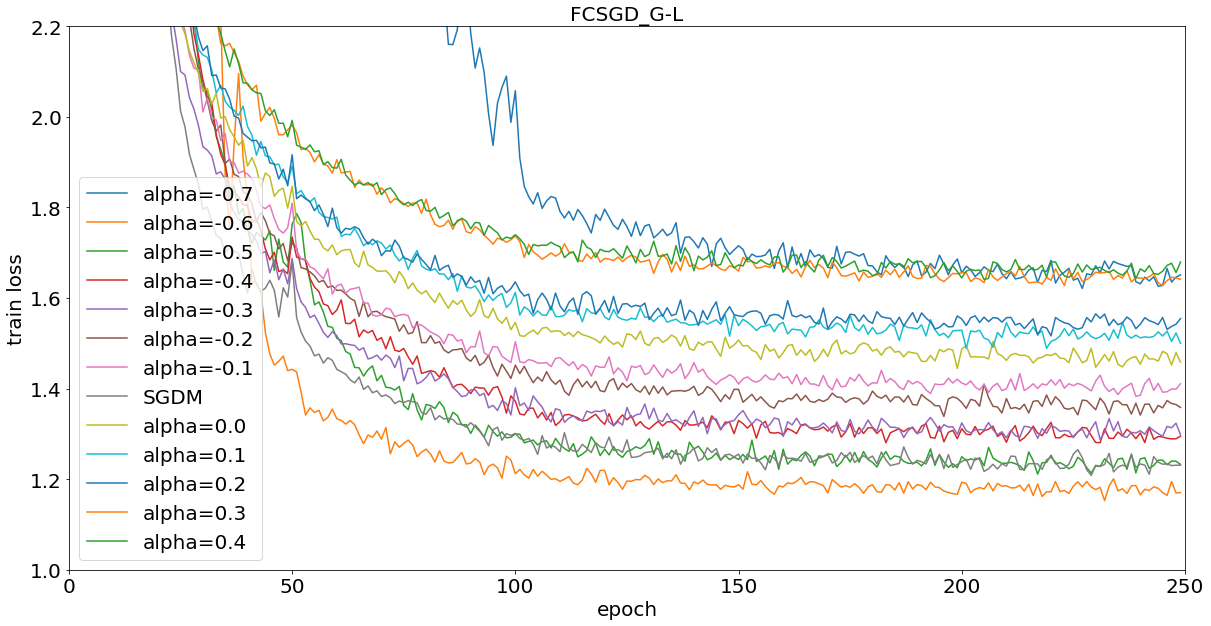

In [59]:
plt.figure(figsize=(20, 10))
plt.plot(E_07,label='alpha=-0.7')
plt.plot(E_06,label='alpha=-0.6')
plt.plot(E_05,label='alpha=-0.5')
plt.plot(E_04,label='alpha=-0.4')
plt.plot(E_03,label='alpha=-0.3')
plt.plot(E_02,label='alpha=-0.2')
plt.plot(E_01,label='alpha=-0.1')
#plt.plot(E_SGD,label='SGD')
plt.plot(E_SGDM,label='SGDM')
plt.plot(E_0,label='alpha=0.0')
plt.plot(E_1,label='alpha=0.1')
plt.plot(E_2,label='alpha=0.2')
plt.plot(E_3,label='alpha=0.3')
plt.plot(E_4,label='alpha=0.4')
plt.ylim(1.00,2.20)
plt.xlim(0,250)
plt.legend(fontsize=20)
plt.tick_params(axis='both',which='major',labelsize=20)
plt.xlabel('epoch', fontsize=20)
plt.ylabel('train loss', fontsize=20)
plt.title('FCSGD_G-L', fontsize=20)
#plt.savefig("D:/NewComputer/2022年8月15日之前出刊论文/mathematics论文撰写/作图代码/图7.svg", dpi=300,format="svg")
plt.show()

In [33]:
#ETTm2 train and test
epoch = 250
batch_size = 256
model = Net()
model.to(device)
criterion = nn.MSELoss()

#choose optimizers
#optimizer = FCSGD_G_L(model.parameters(),lr=0.01,weight_decay=0,r=-0.4)
optimizer = FCAdam_G_L(model.parameters(),lr=0.0001,weight_decay=0,r=0.4)
#optimizer = torch.optim.Adam(model.parameters(),lr=0.0001,weight_decay=0)
#optimizer = torch.optim.SGD(model.parameters(),lr=0.01,weight_decay=0,momentum=0.1)
EA_4 = []
timestart = time.time()
for i in range(epoch):
    if 50<=i<100:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.00005
    if 100<=i<150:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.00001
    if 150<=i<200:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.000005
    if 200<=i<250:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.000001
    loss_sum = 0
    start = np.random.randint(11,size=1)[0]  #Generate a random integer between 0 and 10
    while start+batch_size<len(X_train):
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        start = start+batch_size
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        out,hn = model(X_batch)
        loss = criterion(hn,y_batch)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum +=loss
    EA_4.append(loss_sum.cpu().detach().numpy())
    print('epoch:{0},loss:{1}'.format(i,loss_sum.cpu().detach().numpy()))
torch.save(model.state_dict(), "lstm_best.pth")
timeend = time.time()
spend_time = timeend-timestart
print(spend_time)

epoch:0,loss:59.521034240722656
epoch:1,loss:58.19493865966797
epoch:2,loss:56.8531608581543
epoch:3,loss:50.439266204833984
epoch:4,loss:27.053808212280273
epoch:5,loss:14.089309692382812
epoch:6,loss:9.11839771270752
epoch:7,loss:7.115139961242676
epoch:8,loss:5.74137020111084
epoch:9,loss:5.010286331176758
epoch:10,loss:4.965292930603027
epoch:11,loss:4.318024158477783
epoch:12,loss:4.0096821784973145
epoch:13,loss:3.7541873455047607
epoch:14,loss:3.3266098499298096
epoch:15,loss:3.180208444595337
epoch:16,loss:3.0627312660217285
epoch:17,loss:3.067312002182007
epoch:18,loss:2.8845841884613037
epoch:19,loss:2.838071346282959
epoch:20,loss:2.7628393173217773
epoch:21,loss:2.712714195251465
epoch:22,loss:2.6025993824005127
epoch:23,loss:2.623258352279663
epoch:24,loss:2.6180570125579834
epoch:25,loss:2.621274471282959
epoch:26,loss:2.547720432281494
epoch:27,loss:2.5269739627838135
epoch:28,loss:2.5099964141845703
epoch:29,loss:2.6525464057922363
epoch:30,loss:2.4438443183898926
epoch

epoch:247,loss:1.3748674392700195
epoch:248,loss:1.364945888519287
epoch:249,loss:1.3746932744979858
173.8538258075714


In [46]:
#ETTm2 train and test
epoch = 250
batch_size = 256
model = Net()
model.to(device)
criterion = nn.MSELoss()

#choose optimizers
#optimizer = FCSGD_G_L(model.parameters(),lr=0.01,weight_decay=0,r=-0.4)
optimizer = FCAdam_G_L(model.parameters(),lr=0.0001,weight_decay=0,r=0.5)
#optimizer = torch.optim.Adam(model.parameters(),lr=0.0001,weight_decay=0)
#optimizer = torch.optim.SGD(model.parameters(),lr=0.01,weight_decay=0,momentum=0.1)
EA_5 = []
timestart = time.time()
for i in range(epoch):
    if 50<=i<100:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.00005
    if 100<=i<150:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.00001
    if 150<=i<200:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.000005
    if 200<=i<250:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.000001
    loss_sum = 0
    start = np.random.randint(11,size=1)[0]  #Generate a random integer between 0 and 10
    while start+batch_size<len(X_train):
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        start = start+batch_size
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        out,hn = model(X_batch)
        loss = criterion(hn,y_batch)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum +=loss
    EA_5.append(loss_sum.cpu().detach().numpy())
    print('epoch:{0},loss:{1}'.format(i,loss_sum.cpu().detach().numpy()))
torch.save(model.state_dict(), "lstm_best.pth")
timeend = time.time()
spend_time = timeend-timestart
print(spend_time)

epoch:0,loss:65.18021392822266
epoch:1,loss:63.09439468383789
epoch:2,loss:59.302974700927734
epoch:3,loss:41.693641662597656
epoch:4,loss:20.776702880859375
epoch:5,loss:16.074663162231445
epoch:6,loss:12.40722942352295
epoch:7,loss:8.229588508605957
epoch:8,loss:6.987428665161133
epoch:9,loss:6.4409708976745605
epoch:10,loss:5.776374816894531
epoch:11,loss:4.663463115692139
epoch:12,loss:4.376527309417725
epoch:13,loss:4.228507995605469
epoch:14,loss:3.9123694896698
epoch:15,loss:3.501544952392578
epoch:16,loss:3.413609743118286
epoch:17,loss:3.4097347259521484
epoch:18,loss:3.2018661499023438
epoch:19,loss:3.0268967151641846
epoch:20,loss:2.99855637550354
epoch:21,loss:3.041715145111084
epoch:22,loss:2.8806710243225098
epoch:23,loss:2.8103532791137695
epoch:24,loss:2.9334495067596436
epoch:25,loss:2.9726388454437256
epoch:26,loss:2.612058401107788
epoch:27,loss:2.6780409812927246
epoch:28,loss:2.725552797317505
epoch:29,loss:2.640373468399048
epoch:30,loss:2.6057145595550537
epoch:3

epoch:247,loss:1.448032021522522
epoch:248,loss:1.4607518911361694
epoch:249,loss:1.4595507383346558
174.50023555755615


In [34]:
#ETTm2 train and test
epoch = 250
batch_size = 256
model = Net()
model.to(device)
criterion = nn.MSELoss()

#choose optimizers
#optimizer = FCSGD_G_L(model.parameters(),lr=0.01,weight_decay=0,r=-0.4)
optimizer = FCAdam_G_L(model.parameters(),lr=0.0001,weight_decay=0,r=0.3)
#optimizer = torch.optim.Adam(model.parameters(),lr=0.0001,weight_decay=0)
#optimizer = torch.optim.SGD(model.parameters(),lr=0.01,weight_decay=0,momentum=0.1)
EA_3 = []
timestart = time.time()
for i in range(epoch):
    if 50<=i<100:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.00005
    if 100<=i<150:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.00001
    if 150<=i<200:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.000005
    if 200<=i<250:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.000001
    loss_sum = 0
    start = np.random.randint(11,size=1)[0]  #Generate a random integer between 0 and 10
    while start+batch_size<len(X_train):
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        start = start+batch_size
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        out,hn = model(X_batch)
        loss = criterion(hn,y_batch)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum +=loss
    EA_3.append(loss_sum.cpu().detach().numpy())
    print('epoch:{0},loss:{1}'.format(i,loss_sum.cpu().detach().numpy()))
torch.save(model.state_dict(), "lstm_best.pth")
timeend = time.time()
spend_time = timeend-timestart
print(spend_time)

epoch:0,loss:58.56022262573242
epoch:1,loss:56.9197883605957
epoch:2,loss:52.98798751831055
epoch:3,loss:35.676483154296875
epoch:4,loss:19.392051696777344
epoch:5,loss:11.993842124938965
epoch:6,loss:9.353328704833984
epoch:7,loss:6.522468090057373
epoch:8,loss:5.404271602630615
epoch:9,loss:5.663176536560059
epoch:10,loss:4.620851039886475
epoch:11,loss:4.393868923187256
epoch:12,loss:4.580029010772705
epoch:13,loss:3.6698224544525146
epoch:14,loss:3.9984209537506104
epoch:15,loss:4.843292713165283
epoch:16,loss:3.426805257797241
epoch:17,loss:4.68927526473999
epoch:18,loss:7.469809055328369
epoch:19,loss:3.6609599590301514
epoch:20,loss:5.1958208084106445
epoch:21,loss:7.406189441680908
epoch:22,loss:2.9854605197906494
epoch:23,loss:2.8992910385131836
epoch:24,loss:2.924192190170288
epoch:25,loss:2.721475839614868
epoch:26,loss:2.667064666748047
epoch:27,loss:2.598829984664917
epoch:28,loss:2.5479207038879395
epoch:29,loss:2.518361806869507
epoch:30,loss:2.4816911220550537
epoch:31,

epoch:247,loss:1.3939766883850098
epoch:248,loss:1.419765591621399
epoch:249,loss:1.4115760326385498
174.69293642044067


In [35]:
#ETTm2 train and test
epoch = 250
batch_size = 256
model = Net()
model.to(device)
criterion = nn.MSELoss()

#choose optimizers
#optimizer = FCSGD_G_L(model.parameters(),lr=0.01,weight_decay=0,r=-0.4)
optimizer = FCAdam_G_L(model.parameters(),lr=0.0001,weight_decay=0,r=0.2)
#optimizer = torch.optim.Adam(model.parameters(),lr=0.0001,weight_decay=0)
#optimizer = torch.optim.SGD(model.parameters(),lr=0.01,weight_decay=0,momentum=0.1)
EA_2 = []
timestart = time.time()
for i in range(epoch):
    if 50<=i<100:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.00005
    if 100<=i<150:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.00001
    if 150<=i<200:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.000005
    if 200<=i<250:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.000001
    loss_sum = 0
    start = np.random.randint(11,size=1)[0]  #Generate a random integer between 0 and 10
    while start+batch_size<len(X_train):
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        start = start+batch_size
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        out,hn = model(X_batch)
        loss = criterion(hn,y_batch)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum +=loss
    EA_2.append(loss_sum.cpu().detach().numpy())
    print('epoch:{0},loss:{1}'.format(i,loss_sum.cpu().detach().numpy()))
torch.save(model.state_dict(), "lstm_best.pth")
timeend = time.time()
spend_time = timeend-timestart
print(spend_time)

epoch:0,loss:60.450782775878906
epoch:1,loss:58.79050064086914
epoch:2,loss:55.507808685302734
epoch:3,loss:38.67155456542969
epoch:4,loss:23.765235900878906
epoch:5,loss:15.400169372558594
epoch:6,loss:11.652704238891602
epoch:7,loss:8.1503324508667
epoch:8,loss:8.032615661621094
epoch:9,loss:8.89915657043457
epoch:10,loss:7.244381904602051
epoch:11,loss:5.150714874267578
epoch:12,loss:4.181754112243652
epoch:13,loss:3.7259645462036133
epoch:14,loss:3.5317461490631104
epoch:15,loss:3.36279296875
epoch:16,loss:3.1719539165496826
epoch:17,loss:3.024933338165283
epoch:18,loss:2.896639108657837
epoch:19,loss:2.8212246894836426
epoch:20,loss:2.749586582183838
epoch:21,loss:2.692925453186035
epoch:22,loss:2.640373468399048
epoch:23,loss:2.579052686691284
epoch:24,loss:2.5463500022888184
epoch:25,loss:2.517995834350586
epoch:26,loss:2.486906051635742
epoch:27,loss:2.4687745571136475
epoch:28,loss:2.4537124633789062
epoch:29,loss:2.421232223510742
epoch:30,loss:2.395233392715454
epoch:31,loss

epoch:247,loss:1.3845860958099365
epoch:248,loss:1.3815653324127197
epoch:249,loss:1.3911442756652832
174.9004545211792


In [42]:
#ETTm2 train and test
epoch = 250
batch_size = 256
model = Net()
model.to(device)
criterion = nn.MSELoss()

#choose optimizers
#optimizer = FCSGD_G_L(model.parameters(),lr=0.01,weight_decay=0,r=-0.4)
optimizer = FCAdam_G_L(model.parameters(),lr=0.0001,weight_decay=0,r=0.1)
#optimizer = torch.optim.Adam(model.parameters(),lr=0.0001,weight_decay=0)
#optimizer = torch.optim.SGD(model.parameters(),lr=0.01,weight_decay=0,momentum=0.1)
EA_1 = []
timestart = time.time()
for i in range(epoch):
    if 50<=i<100:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.00005
    if 100<=i<150:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.00001
    if 150<=i<200:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.000005
    if 200<=i<250:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.000001
    loss_sum = 0
    start = np.random.randint(11,size=1)[0]  #Generate a random integer between 0 and 10
    while start+batch_size<len(X_train):
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        start = start+batch_size
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        out,hn = model(X_batch)
        loss = criterion(hn,y_batch)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum +=loss
    EA_1.append(loss_sum.cpu().detach().numpy())
    print('epoch:{0},loss:{1}'.format(i,loss_sum.cpu().detach().numpy()))
torch.save(model.state_dict(), "lstm_best.pth")
timeend = time.time()
spend_time = timeend-timestart
print(spend_time)

epoch:0,loss:62.29010772705078
epoch:1,loss:60.56511306762695
epoch:2,loss:57.675785064697266
epoch:3,loss:41.918270111083984
epoch:4,loss:19.136690139770508
epoch:5,loss:17.718585968017578
epoch:6,loss:11.100099563598633
epoch:7,loss:7.012387275695801
epoch:8,loss:5.9077887535095215
epoch:9,loss:5.339770793914795
epoch:10,loss:4.677470684051514
epoch:11,loss:4.33697509765625
epoch:12,loss:4.0460638999938965
epoch:13,loss:3.904003381729126
epoch:14,loss:3.9425885677337646
epoch:15,loss:3.315075397491455
epoch:16,loss:3.195709705352783
epoch:17,loss:2.9567906856536865
epoch:18,loss:3.870666742324829
epoch:19,loss:4.806320667266846
epoch:20,loss:5.0997772216796875
epoch:21,loss:5.775676727294922
epoch:22,loss:3.738766670227051
epoch:23,loss:4.612149238586426
epoch:24,loss:4.716876029968262
epoch:25,loss:3.229590892791748
epoch:26,loss:5.04256534576416
epoch:27,loss:8.694476127624512
epoch:28,loss:3.664102792739868
epoch:29,loss:5.633351802825928
epoch:30,loss:7.751151084899902
epoch:31,l

epoch:247,loss:1.41890549659729
epoch:248,loss:1.4045398235321045
epoch:249,loss:1.389443278312683
176.32817697525024


In [43]:
#ETTm2 train and test
epoch = 250
batch_size = 256
model = Net()
model.to(device)
criterion = nn.MSELoss()

#choose optimizers
#optimizer = FCSGD_G_L(model.parameters(),lr=0.01,weight_decay=0,r=-0.4)
optimizer = FCAdam_G_L(model.parameters(),lr=0.0001,weight_decay=0,r=0.0)
#optimizer = torch.optim.Adam(model.parameters(),lr=0.0001,weight_decay=0)
#optimizer = torch.optim.SGD(model.parameters(),lr=0.01,weight_decay=0,momentum=0.1)
EA_0 = []
timestart = time.time()
for i in range(epoch):
    if 50<=i<100:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.00005
    if 100<=i<150:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.00001
    if 150<=i<200:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.000005
    if 200<=i<250:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.000001
    loss_sum = 0
    start = np.random.randint(11,size=1)[0]  #Generate a random integer between 0 and 10
    while start+batch_size<len(X_train):
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        start = start+batch_size
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        out,hn = model(X_batch)
        loss = criterion(hn,y_batch)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum +=loss
    EA_0.append(loss_sum.cpu().detach().numpy())
    print('epoch:{0},loss:{1}'.format(i,loss_sum.cpu().detach().numpy()))
torch.save(model.state_dict(), "lstm_best.pth")
timeend = time.time()
spend_time = timeend-timestart
print(spend_time)

epoch:0,loss:66.6389389038086
epoch:1,loss:64.14603424072266
epoch:2,loss:60.80707550048828
epoch:3,loss:45.8353271484375
epoch:4,loss:26.954158782958984
epoch:5,loss:21.749664306640625
epoch:6,loss:12.508976936340332
epoch:7,loss:9.222639083862305
epoch:8,loss:6.818356513977051
epoch:9,loss:7.085957050323486
epoch:10,loss:6.479837417602539
epoch:11,loss:5.17835807800293
epoch:12,loss:4.636301040649414
epoch:13,loss:5.004059791564941
epoch:14,loss:4.385748863220215
epoch:15,loss:4.878546714782715
epoch:16,loss:4.033966541290283
epoch:17,loss:2.98327374458313
epoch:18,loss:3.4008142948150635
epoch:19,loss:3.713669538497925
epoch:20,loss:3.1122853755950928
epoch:21,loss:3.9849843978881836
epoch:22,loss:3.779995918273926
epoch:23,loss:2.7089478969573975
epoch:24,loss:3.1903977394104004
epoch:25,loss:3.1631052494049072
epoch:26,loss:2.5880613327026367
epoch:27,loss:3.087681531906128
epoch:28,loss:2.9100024700164795
epoch:29,loss:2.483232021331787
epoch:30,loss:2.6356210708618164
epoch:31,l

epoch:247,loss:1.3731991052627563
epoch:248,loss:1.378670334815979
epoch:249,loss:1.3889293670654297
173.86300587654114


In [44]:
#ETTm2 train and test
epoch = 250
batch_size = 256
model = Net()
model.to(device)
criterion = nn.MSELoss()

#choose optimizers
#optimizer = FCSGD_G_L(model.parameters(),lr=0.01,weight_decay=0,r=-0.4)
optimizer = FCAdam_G_L(model.parameters(),lr=0.0001,weight_decay=0,r=-0.1)
#optimizer = torch.optim.Adam(model.parameters(),lr=0.0001,weight_decay=0)
#optimizer = torch.optim.SGD(model.parameters(),lr=0.01,weight_decay=0,momentum=0.1)
EA_01 = []
timestart = time.time()
for i in range(epoch):
    if 50<=i<100:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.00005
    if 100<=i<150:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.00001
    if 150<=i<200:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.000005
    if 200<=i<250:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.000001
    loss_sum = 0
    start = np.random.randint(11,size=1)[0]  #Generate a random integer between 0 and 10
    while start+batch_size<len(X_train):
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        start = start+batch_size
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        out,hn = model(X_batch)
        loss = criterion(hn,y_batch)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum +=loss
    EA_01.append(loss_sum.cpu().detach().numpy())
    print('epoch:{0},loss:{1}'.format(i,loss_sum.cpu().detach().numpy()))
torch.save(model.state_dict(), "lstm_best.pth")
timeend = time.time()
spend_time = timeend-timestart
print(spend_time)

epoch:0,loss:59.06486129760742
epoch:1,loss:57.58094024658203
epoch:2,loss:53.827476501464844
epoch:3,loss:34.91765594482422
epoch:4,loss:21.017866134643555
epoch:5,loss:17.731327056884766
epoch:6,loss:10.988859176635742
epoch:7,loss:6.8162150382995605
epoch:8,loss:5.723894119262695
epoch:9,loss:5.329870223999023
epoch:10,loss:4.607550144195557
epoch:11,loss:4.259860992431641
epoch:12,loss:4.323990821838379
epoch:13,loss:3.9587042331695557
epoch:14,loss:4.989194393157959
epoch:15,loss:9.199780464172363
epoch:16,loss:7.1447529792785645
epoch:17,loss:9.724754333496094
epoch:18,loss:10.151824951171875
epoch:19,loss:3.6029670238494873
epoch:20,loss:3.3369884490966797
epoch:21,loss:3.005662441253662
epoch:22,loss:2.903078079223633
epoch:23,loss:2.7804670333862305
epoch:24,loss:2.6798648834228516
epoch:25,loss:2.742990493774414
epoch:26,loss:2.762166738510132
epoch:27,loss:2.609095335006714
epoch:28,loss:2.481635332107544
epoch:29,loss:2.5809335708618164
epoch:30,loss:2.5259926319122314
epoc

epoch:247,loss:1.4721784591674805
epoch:248,loss:1.4692425727844238
epoch:249,loss:1.4447757005691528
177.8785719871521


In [39]:
#ETTm2 train and test
epoch = 250
batch_size = 256
model = Net()
model.to(device)
criterion = nn.MSELoss()

#choose optimizers
#optimizer = FCSGD_G_L(model.parameters(),lr=0.01,weight_decay=0,r=-0.4)
#optimizer = FCAdam_G_L(model.parameters(),lr=0.0001,weight_decay=0,r=0.2)
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001,weight_decay=0)
#optimizer = torch.optim.SGD(model.parameters(),lr=0.01,weight_decay=0,momentum=0.1)
EA_Adam = []
timestart = time.time()
for i in range(epoch):
    if 50<=i<100:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.00005
    if 100<=i<150:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.00001
    if 150<=i<200:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.000005
    if 200<=i<250:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 0.000001
    loss_sum = 0
    start = np.random.randint(11,size=1)[0]  #Generate a random integer between 0 and 10
    while start+batch_size<len(X_train):
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
        start = start+batch_size
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        out,hn = model(X_batch)
        loss = criterion(hn,y_batch)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        loss_sum +=loss
    EA_Adam.append(loss_sum.cpu().detach().numpy())
    print('epoch:{0},loss:{1}'.format(i,loss_sum.cpu().detach().numpy()))
torch.save(model.state_dict(), "lstm_best.pth")
timeend = time.time()
spend_time = timeend-timestart
print(spend_time)

epoch:0,loss:63.24419403076172
epoch:1,loss:61.53444290161133
epoch:2,loss:59.29972839355469
epoch:3,loss:51.60997772216797
epoch:4,loss:27.526691436767578
epoch:5,loss:16.27771759033203
epoch:6,loss:12.103342056274414
epoch:7,loss:9.30964183807373
epoch:8,loss:6.883017539978027
epoch:9,loss:5.642632961273193
epoch:10,loss:5.142874717712402
epoch:11,loss:4.730360507965088
epoch:12,loss:4.205900192260742
epoch:13,loss:3.8863916397094727
epoch:14,loss:3.7010796070098877
epoch:15,loss:3.531614065170288
epoch:16,loss:3.3396637439727783
epoch:17,loss:3.190592050552368
epoch:18,loss:3.096710443496704
epoch:19,loss:2.9859509468078613
epoch:20,loss:2.8790090084075928
epoch:21,loss:2.8150229454040527
epoch:22,loss:2.768049478530884
epoch:23,loss:2.696685552597046
epoch:24,loss:2.6363651752471924
epoch:25,loss:2.585315704345703
epoch:26,loss:2.584979772567749
epoch:27,loss:2.5509045124053955
epoch:28,loss:2.507772922515869
epoch:29,loss:2.460374355316162
epoch:30,loss:2.450554132461548
epoch:31,

epoch:247,loss:1.4772015810012817
epoch:248,loss:1.4923537969589233
epoch:249,loss:1.480720043182373
137.8845672607422


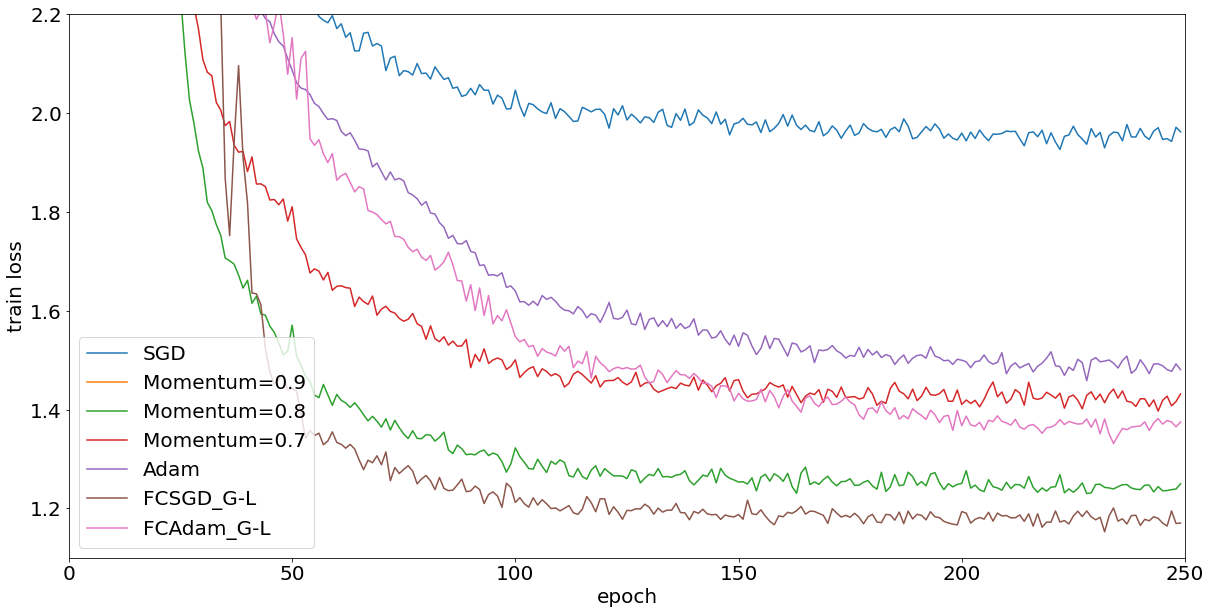

In [76]:
plt.figure(figsize=(20, 10))
plt.plot(E_SGD,label='SGD')
plt.plot(E_SGDM9,label='Momentum=0.9')
plt.plot(E_SGDM8,label='Momentum=0.8')
plt.plot(E_SGDM7,label='Momentum=0.7')
plt.plot(EA_Adam,label='Adam')
plt.plot(E_06,label='FCSGD_G-L')
plt.plot(EA_4,label='FCAdam_G-L')
plt.ylim(1.10,2.20)
plt.xlim(0,250)
plt.legend(fontsize=20)
plt.tick_params(axis='both',which='major',labelsize=20)
plt.xlabel('epoch', fontsize=20)
plt.ylabel('train loss', fontsize=20)
#plt.title('FCAdam_G-L', fontsize=20)
plt.show()

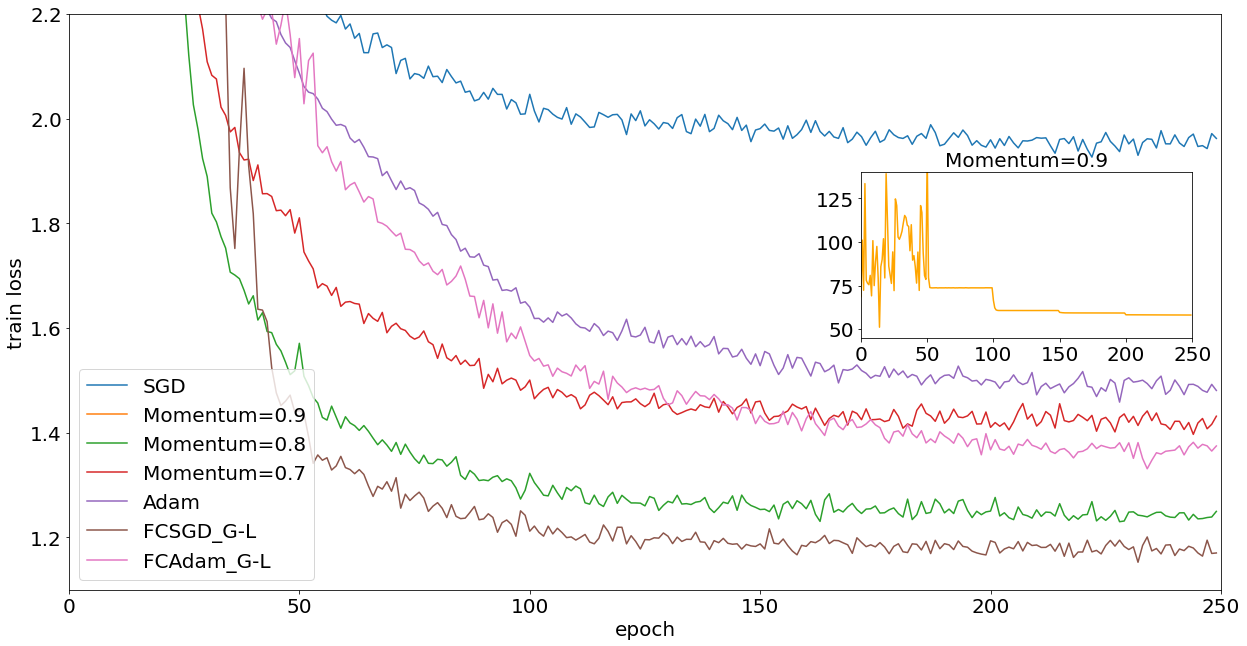

In [141]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 10))
left, bottom, width, height = 0.1,0.1,0.8,0.8
ax1 = fig.add_axes([left,bottom,width,height])
ax1.plot(E_SGD,label='SGD')
ax1.plot(E_SGDM9,label='Momentum=0.9')
ax1.plot(E_SGDM8,label='Momentum=0.8')
ax1.plot(E_SGDM7,label='Momentum=0.7')
ax1.plot(EA_Adam,label='Adam')
ax1.plot(E_06,label='FCSGD_G-L')
ax1.plot(EA_4,label='FCAdam_G-L')
ax1.legend(fontsize=20)
ax1.set_ylim(1.10,2.20)
ax1.set_xlim(0,250)
ax1.tick_params(axis='both',which='major',labelsize=20)
ax1.set_xlabel('epoch', fontsize=20)
ax1.set_ylabel('train loss', fontsize=20)
#ax1.set_title('title')


left, bottom, width, height = 0.65,0.45,0.23,0.23
ax2 = fig.add_axes([left,bottom,width,height])
ax2.plot(E_SGDM9,color='orange')
ax2.set_ylim(45,140)
ax2.set_xlim(0,250)
ax2.tick_params(axis='both',which='major',labelsize=20)
ax2.set_title('Momentum=0.9',fontsize=20)
#ax2.legend(fontsize=20)
plt.show()